In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.image as imread
import numpy as np
import random
import os
import time
from IPython.display import clear_output
from sklearn.utils import shuffle
import pandas as pd
import scipy.stats as scp
from sklearn.metrics import roc_curve, auc

from google.colab import drive
drive.mount('/content/drive')

TensorFlow 2.x selected.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
start_time = time.time()

!unzip '/content/drive/My Drive/SPACE_DATA/cae_train.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/novel_images.zip'

clear_output()
print('UNZIPPING TIME = {}\n'.format(time.time()-start_time))

UNZIPPING TIME = 554.2125296592712



In [0]:
novel_path = []
for path in os.listdir('/content/novel_images'):
    if path != '.DS_Store':
      full_path = os.path.join('/content/novel_images', path)
      novel_path.append(full_path)

typical_path = []
for path in os.listdir('/content/cae_train'):
    if path != '.DS_Store':
      full_path = os.path.join('/content/cae_train', path)
      typical_path.append(full_path)

In [4]:
start_time = time.time()

for i in range (len(typical_path)):
  path = typical_path[i]
  image = np.load(path).astype('float32')
  np.save(path, image)

for i in range (len(novel_path)):
  path = novel_path[i]
  image = np.load(path).astype('float32')
  np.save(path, image)

print('CONVERTING TIME = {}\n'.format(time.time()-start_time))

CONVERTING TIME = 711.6667368412018



In [5]:
print(np.shape(novel_path))
print(np.shape(typical_path))

(332,)
(98800,)


In [0]:
def load_images(image_paths):
  images = []
  if np.shape(image_paths) == ():
    images.append(np.load(image_paths))
  else:
    for path in image_paths:
      img = np.load(path)
      images.append(img)
  return np.array(images)

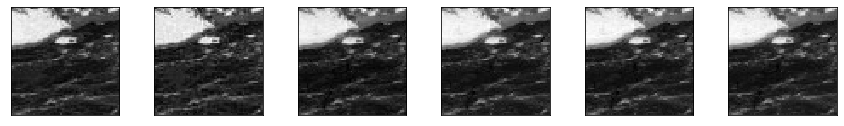

In [7]:
def plot_image(image):
    plot = plt.figure(figsize=[15,2])
    for i in range(6):
        plt.subplot(1, 6, i+1)
        plt.xticks([]); plt.yticks([])
        plt.imshow(image[0,:,:,i], cmap=plt.cm.binary)
    plt.show()

plot_image(load_images(typical_path[0]))

In [0]:
class CVAE(tf.keras.Model):
    def __init__(self, z_size):
        super(CVAE, self).__init__()
        self.z_size = z_size
        self.encoder_nn = tf.keras.models.Sequential([
                          tf.keras.layers.Input((64, 64, 6)),                          
                          tf.keras.layers.Conv2D(12, (7,7), strides = (1,1), padding = 'SAME', activation='relu'),
                          tf.keras.layers.Conv2D(8, (5,5), strides = (2,2), padding = 'SAME', activation='relu'),
                          tf.keras.layers.Conv2D(6, (3,3), strides = (2,2), padding = 'SAME', activation='relu'),
                          tf.keras.layers.Flatten(),
                          tf.keras.layers.Dense(z_size*2)
                          ], name='Encoder')

        self.decoder_nn = tf.keras.models.Sequential([
                          tf.keras.layers.Dense(768, activation='relu', input_shape=(z_size,)),
                          tf.keras.layers.Reshape(target_shape=(16, 16, 3)),
                          tf.keras.layers.Conv2DTranspose(8, (3,3), strides = (2,2), padding = 'SAME', activation='relu'),
                          tf.keras.layers.Conv2DTranspose(12, (5,5), strides = (2,2), padding = 'SAME'),
                          tf.keras.layers.Conv2DTranspose(6, (7,7), strides = (1,1), padding = 'SAME'),
                          ], name='Decoder')

    def encode(self, x):
        encoder_nn_output = self.encoder_nn(x)
        z_mean, z_logvar = tf.split(encoder_nn_output, num_or_size_splits=2, axis=1)
        return z_mean, z_logvar

    def reparameterize(self, z_mean, z_logvar):
        epsilon = tf.random.normal(shape=z_mean.shape)
        z_sampled = epsilon * tf.exp(z_logvar * 0.5) + z_mean
        return z_sampled
      
    def decode(self, z):
        pixel_output = self.decoder_nn(z)
        return pixel_output

model = CVAE(768)
#model.encoder_nn.summary()
#model.decoder_nn.summary()

In [0]:
def calculate_ELBO(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  pixel_prob = tf.math.sigmoid(x_logit)

  variance = 0.2**2
  logpx_z = tf.reduce_sum(-.5 * (((x - pixel_prob) ** 2. / variance) + tf.math.log(variance * 2.0 * np.pi)), axis=[1, 2, 3])
  KL = -0.5*(tf.reduce_sum(tf.math.add(logvar,1), axis=1) - tf.reduce_sum(tf.exp(logvar), axis=1) - tf.reduce_sum(tf.exp(mean ** 2), axis=1))

  #print('recon = ' + str(tf.reduce_mean(logpx_z).numpy()))
  #print('KL = ' + str(tf.reduce_mean(KL).numpy()))

  return -tf.reduce_mean(logpx_z - KL)

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [0]:
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = calculate_ELBO(model, x)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        #train_loss(loss)
    return loss

def test_step(model, x, optimizer):
    loss = calculate_ELBO(model, x)
    test_loss(loss)

def train_only_dataset(model, train_dataset, epochs):  
  for epoch in range(epochs):
    for train_x in train_dataset: 

      train_step(model, train_x, optimizer)

    loss = -train_loss.result()
     
  train_loss.reset_states()
  return loss

In [0]:
#typical_test_idx = random.sample(range(0, 98800), 1000)
typical_test_idx = list((np.linspace(0,98800-1, 100)).astype('int'))
typical_train_idx = list(range(98800))
for i in typical_test_idx:
  typical_train_idx.remove(i)

typical_test_path = []
typical_train_path = []
for i in typical_test_idx:
  typical_test_path.append(typical_path[i])
for i in typical_train_idx:
  typical_train_path.append(typical_path[i])

#novel_test_idx = random.sample(range(0, 332), 166)
novel_test_idx = list(np.linspace(0,331,32).astype('int'))
novel_train_idx = list(range(332))
for i in novel_test_idx:
  novel_train_idx.remove(i)

novel_test_path = []
novel_train_path = []
for i in novel_test_idx:
  novel_test_path.append(novel_path[i])
for i in novel_train_idx:
  novel_train_path.append(novel_path[i])

In [13]:
print(np.shape(typical_train_path))
print(np.shape(typical_test_path))
print(np.shape(novel_train_path))
print(np.shape(novel_test_path))

(98700,)
(100,)
(300,)
(32,)


In [0]:
N_typical_images_train = len(typical_train_path)
N_typical_images_test = len(typical_test_path)
N_novel_images_train = len(novel_train_path)
N_novel_images_test = len(novel_test_path)
img_height = load_images(typical_train_path[0]).shape[1]
img_width = load_images(typical_train_path[0]).shape[2]
img_channels = load_images(typical_train_path[0]).shape[3]
input_range = 255

In [0]:
def setup_dataset(x):
  images = x/input_range

  batch_size = 100
  dataset = tf.data.Dataset.from_tensor_slices((images)).shuffle(len(images)).batch(batch_size)
  return dataset

def setup_dataset_no_shuffle(x):
  images = x/input_range

  batch_size = 100
  dataset = tf.data.Dataset.from_tensor_slices((images)).batch(batch_size)
  return dataset

In [16]:
z_size = 768
model = CVAE(z_size)
model.encoder_nn.load_weights('/content/drive/My Drive/SPACE_DATA/Novelty_VAE_Encoder/')
model.decoder_nn.load_weights('/content/drive/My Drive/SPACE_DATA/Novelty_VAE_Decoder/')

In [0]:
batch_size = 100
batches_typical_images_train = (N_typical_images_train//batch_size)
epochs = 10

start_time = time.time()
losses = []
for j in range(epochs):
  typical_train_path = shuffle(typical_train_path, random_state=0)
  for i in range(batches_typical_images_train):
    images = load_images(typical_train_path[i*100:(i+1)*100])
    x = (images/255).astype('float32')
    loss = train_step(model, x, optimizer)
    losses = np.append(losses, loss.numpy())

    if i%10 == 0:
      clear_output()
      print(str(j) + '.' + str(i) + ' ---> ' + str(loss.numpy()))
      plt.plot(range(len(losses)), losses)
      plt.grid(which='both', axis='both')
      plt.show()

  #model.encoder_nn.save_weights('/content/drive/My Drive/SPACE_DATA/Novelty_VAE_Encoder/')
  #model.decoder_nn.save_weights('/content/drive/My Drive/SPACE_DATA/Novelty_VAE_Decoder/')

print('TRAINING TIME = {}\n'.format(time.time()-start_time))

Original Pictures:


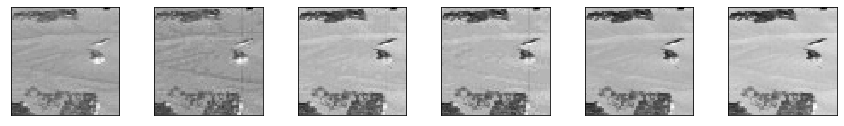

Reconstructed Pictures


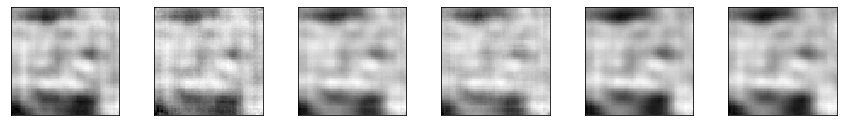

15680.729
Original Pictures:


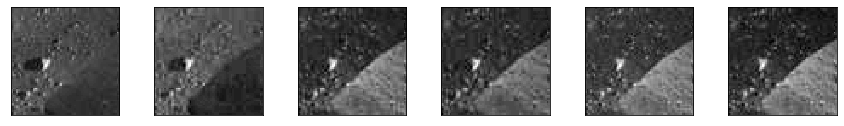

Reconstructed Pictures


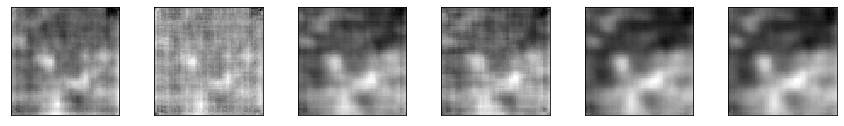

15986.691
Original Pictures:


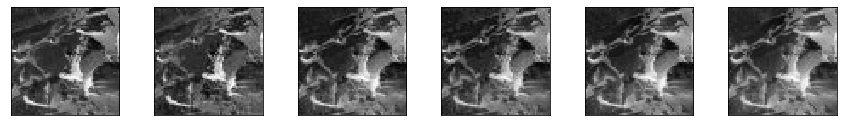

Reconstructed Pictures


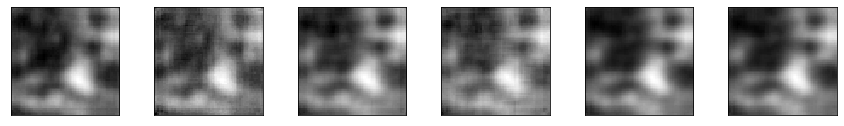

15608.792
Original Pictures:


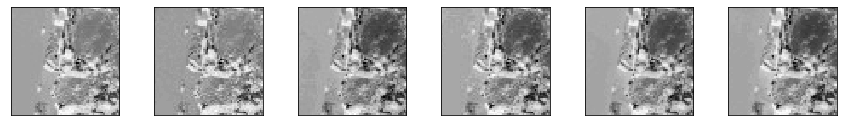

Reconstructed Pictures


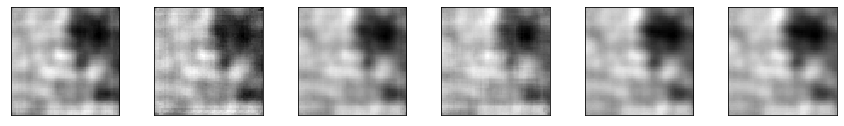

15266.549
Original Pictures:


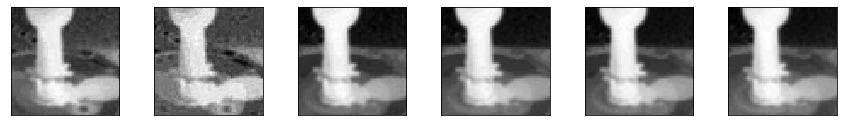

Reconstructed Pictures


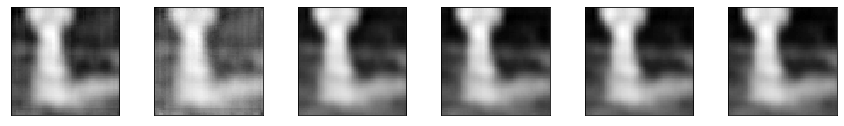

16129.658


In [17]:
def reconstruct_images(image_path):
    images = load_images(image_path)
    x = (images/255).astype('float32')

    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    pixel_output = model.decode(z)
    pixel_prob = tf.math.sigmoid(pixel_output)
    
    loss = -calculate_ELBO(model,x)
    loss = loss
    
    print('Original Pictures:')
    plot_image(x)
    print('Reconstructed Pictures')
    plot_image(pixel_prob)
    return loss

for i in range(5):
  loss = reconstruct_images(typical_train_path[i])
  print(loss.numpy())

14.279268026351929


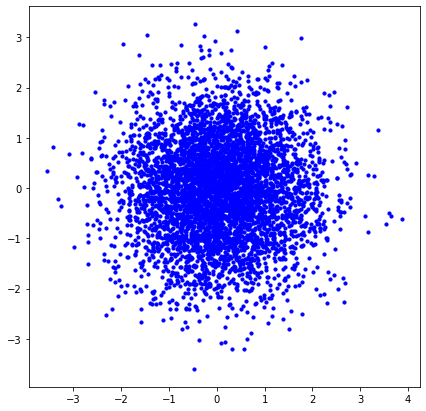

In [18]:
def visualize_latent_space(model, paths, dimensions):
  plot = plt.figure(figsize=[7,7])
  outliers=0
  outlier = []
  latent_space = np.ndarray([0, model.z_size])
  for i in range(len(paths)//100):
      x = load_images(paths[i*100:(i+1)*100])
      x = (x/input_range).astype('float32')
      z_mean, z_logvar = model.encode(x)
      z = model.reparameterize(z_mean, z_logvar)
      latent_space = np.append(latent_space, z, axis=0)


  plt.scatter(latent_space[:, dimensions[0]], latent_space[:,dimensions[1]], color = 'blue', s=10)

  return latent_space, outlier

start_time = time.time()
latent_space, outlier = visualize_latent_space(model, typical_train_path[0:5000], [0,5])
print(time.time()-start_time)

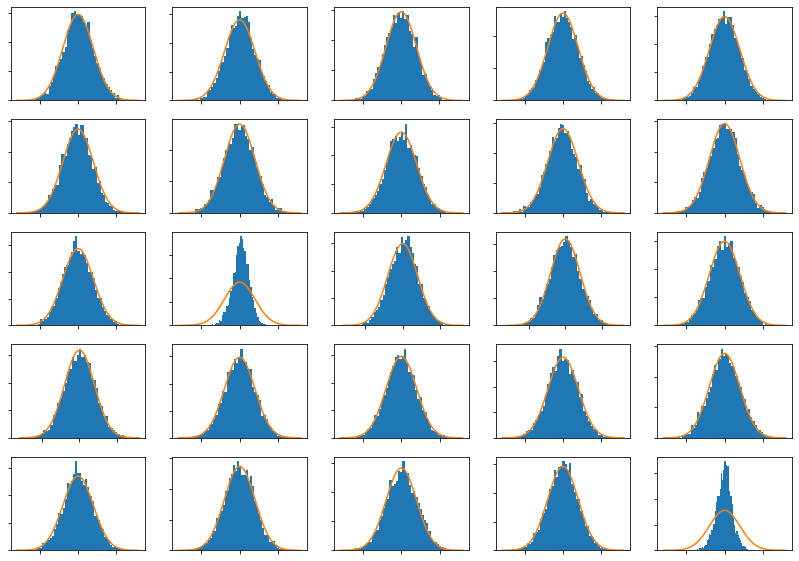

In [19]:
fig, axs = plt.subplots(5,5, figsize=(14, 10))
axs = axs.ravel()

a=0
for i in range(25):
    bins = 50
    scale = ((np.max(latent_space[:,i])-np.min(latent_space[:,i]))/bins)*len(latent_space[:,i])
    x_axis = np.arange(-4, 4, 0.001)
    axs[a].hist(latent_space[:,i], bins)
    y_vals = axs[a].get_yticks()
    axs[a].set_yticklabels([])
    axs[a].set_xticklabels([])
    axs[a].plot(x_axis, scp.norm.pdf(x_axis,0,1)*scale)
    a += 1
plt.show()

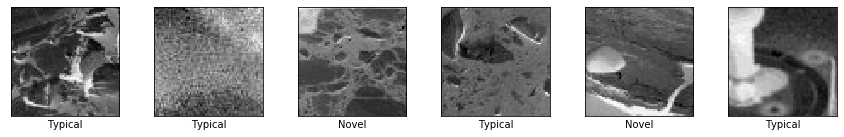

In [20]:
image1=load_images(typical_path[3])
image2=load_images(typical_path[12])
image3=load_images(novel_path[4])
image4=load_images(typical_path[6])
image5=load_images(novel_path[9])
image6=load_images(typical_path[15])

image = np.append(image1, image2, axis=0)
image = np.append(image, image3, axis=0)
image = np.append(image, image4, axis=0)
image = np.append(image, image5, axis=0)
image = np.append(image, image6, axis=0)
plot = plt.figure(figsize=[15,2])
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.xticks([]); plt.yticks([])
    plt.imshow(image[i,:,:,0], cmap=plt.cm.binary)
    if i ==4:
      plt.xlabel('Novel')
    else:
      plt.xlabel('Typical')
    if i == 2:
      plt.xlabel('Novel')
plt.show()

Loss_1 = Deterministic reconstruction error

Loss_2 = Encoder-stochastic reconstruction error average

Loss_3 = Encoder-stochastic reconstruction error minimum

Loss_4 = Deterministic reconstruction likelihood

Loss_5 = Encoder-stochastic reconstruction likelihood average

Loss_6 = Encoder-stochastic reconstruction likelihood minimum

Loss_7 = Fully deterministic distance-based reconstruction error

Loss_8 = Test deterministic distance-based reconstruction error

Loss_9 = Train deterministic distance-based reconstruction error

Loss_10 = Bhattacharyya distance of deterministic reconstruction likelihood

Loss_11 = ELBO

Loss_12 = ELBO average

Loss_13 = ELBO minimum

Loss_14 = KL Divergence

Loss_15 = Euclidean distance between means of the distributions

Loss_16 = Bhattacharyya distance between distributions

Loss_17 = Density latent space 

In [0]:
def Loss_1(model, x):
  losses_per_image = []
  for images in x:

    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    pixel_prob = tf.math.sigmoid(pixel_prob)

    pixel_squared = tf.math.square(pixel_prob - images)
    pixel_squared = tf.reduce_sum(pixel_squared, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, pixel_squared)
  return losses_per_image

def Loss_2(model, x):
  losses_per_image = []
  for images in x:

    z_mean, z_logvar = model.encode(images)
    avg = np.empty([25, len(images)])
    for j in range(25):
      z = model.reparameterize(z_mean, z_logvar)
      pixel_prob = model.decode(z)
      pixel_prob = tf.math.sigmoid(pixel_prob)

      pixel_squared = np.square(pixel_prob - images)
      pixel_squared = tf.reduce_sum(pixel_squared, axis=[1,2,3])
      avg[j,:] = pixel_squared
    losses_per_image = np.append(losses_per_image, np.mean(avg, axis=0))
  return losses_per_image

def Loss_3(model, x):
  losses_per_image = []
  for images in x:

    z_mean, z_logvar = model.encode(images)
    avg = np.empty([25, len(images)])
    for j in range(25):
      z = model.reparameterize(z_mean, z_logvar)
      pixel_prob = model.decode(z)
      pixel_prob = tf.math.sigmoid(pixel_prob)

      pixel_squared = np.square(pixel_prob - images)
      pixel_squared = tf.reduce_sum(pixel_squared, axis=[1,2,3])
      avg[j,:] = pixel_squared
    losses_per_image = np.append(losses_per_image, np.min(avg, axis=0))
  return losses_per_image

def Loss_4(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    pixel_prob = tf.math.sigmoid(pixel_prob)

    variance = 0.2**2
    logpx_z = tf.reduce_sum(-.5 * (((images - pixel_prob) ** 2. / variance) + tf.math.log(variance * 2.0 * 3.14)), axis=[1, 2, 3])
    losses_per_image = np.append(losses_per_image, logpx_z)
  return -losses_per_image

def Loss_5(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    avg = np.empty([25, len(images)])
    for j in range(25):
      z = model.reparameterize(z_mean, z_logvar)
      pixel_prob = model.decode(z)
      pixel_prob = tf.math.sigmoid(pixel_prob)

      variance = 0.2**2
      logpx_z = tf.reduce_sum(-.5 * (((images - pixel_prob) ** 2. / variance) + tf.math.log(variance * 2.0 * np.pi)), axis=[1, 2, 3])
      avg[j,:] = logpx_z
    losses_per_image = np.append(losses_per_image, np.mean(avg, axis=0))
  return -losses_per_image

def Loss_6(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)
    avg = np.empty([25, len(images)])
    for j in range(25):
      z = model.reparameterize(z_mean, z_logvar)
      pixel_prob = model.decode(z)
      pixel_prob = tf.math.sigmoid(pixel_prob)

      variance = 0.2**2
      logpx_z = tf.reduce_sum(-.5 * (((images - pixel_prob) ** 2. / variance) + tf.math.log(variance * 2.0 * np.pi)), axis=[1, 2, 3])
      avg[j,:] = logpx_z
    losses_per_image = np.append(losses_per_image, np.min(avg, axis=0))
  return -losses_per_image

def Loss_7(model, x_train, x_test):
  losses_per_image = []
  pixel_prob_per_image_train = np.empty([0,64,64,6])
  pixel_prob_per_image_test = np.empty([0,64,64,6])
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    pixel_prob = tf.math.sigmoid(pixel_prob)
    pixel_prob_per_image_train = np.append(pixel_prob_per_image_train, pixel_prob, axis=0)
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    pixel_prob = tf.math.sigmoid(pixel_prob)
    pixel_prob_per_image_test = np.append(pixel_prob_per_image_test, pixel_prob, axis=0) 
  num = len(pixel_prob_per_image_test)
  for i in range(num):
    #if not i%100: clear_output(); print('Progress Loss_7:{}%'.format(100*(i)/num))
    temporary = np.abs(pixel_prob_per_image_test[i] - pixel_prob_per_image_train)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_8(model, x_train, x_test):
  losses_per_image = []
  image_train = np.empty([0,64,64,6])
  pixel_prob_per_image_test = np.empty([0,64,64,6])
  for images in x_train:
    image_train = np.append(image_train, images, axis=0)
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    pixel_prob = tf.math.sigmoid(pixel_prob)
    pixel_prob_per_image_test = np.append(pixel_prob_per_image_test, pixel_prob, axis=0)
  num = len(pixel_prob_per_image_test)
  for i in range(num):
    #if not i%100: clear_output(); print('Progress Loss_9:{}%'.format(100*(i)/num))
    temporary = np.abs(pixel_prob_per_image_test[i] - image_train)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_9(model, x_train, x_test):
  losses_per_image = []
  pixel_prob_per_image_train = np.empty([0,64,64,6])
  image_test = np.empty([0,64,64,6])
  for images in x_test:
    image_test = np.append(image_test, images, axis=0)
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    pixel_prob = tf.math.sigmoid(pixel_prob)
    pixel_prob_per_image_train = np.append(pixel_prob_per_image_train, pixel_prob, axis=0)
  num = len(image_test)
  for i in range(num):
    #if not i%100: clear_output(); print('Progress Loss_9:{}%'.format(100*(i)/num))
    temporary = np.abs(image_test[i] - pixel_prob_per_image_train)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_10(model, x_train, x_test):
  losses_per_image = []
  pixel_prob_per_image_train = np.empty([0,64,64,6])
  pixel_prob_per_image_test = np.empty([0,64,64,6])
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    pixel_prob = tf.math.sigmoid(pixel_prob)
    pixel_prob_per_image_train = np.append(pixel_prob_per_image_train, pixel_prob, axis=0)
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    pixel_prob = tf.math.sigmoid(pixel_prob)
    pixel_prob_per_image_test = np.append(pixel_prob_per_image_test, pixel_prob, axis=0) 
  num = len(pixel_prob_per_image_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_8:{}%'.format(100*(i)/num))
    temporary = np.sqrt(np.multiply(1-pixel_prob_per_image_test[i],np.subtract(1,pixel_prob_per_image_train)))+np.sqrt(np.multiply(pixel_prob_per_image_test[i],pixel_prob_per_image_train))
    temporary = np.log(temporary)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_11(model, x):
  losses_per_image = -Loss_4(model, x)-Loss_14(model, x)
  return -losses_per_image

def Loss_12(model, x):
  losses_per_image = -Loss_5(model, x)-Loss_14(model, x)
  return -losses_per_image

def Loss_13(model, x):
  losses_per_image = -Loss_6(model, x)-Loss_14(model, x)
  return -losses_per_image

def Loss_14(model, x):
  losses_per_image = []
  for images in x:
    z_mean, z_logvar = model.encode(images)

    KL = -0.5*(tf.reduce_sum(tf.math.add(z_logvar,1), axis=1) - tf.reduce_sum(tf.exp(z_logvar), axis=1) - tf.reduce_sum(tf.exp(z_mean ** 2), axis=1))
    losses_per_image = np.append(losses_per_image, KL)
  return -losses_per_image

def Loss_15(model, x_train, x_test):
  losses_per_image = []
  z_mean_per_image_train = []
  z_mean_per_image_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    if a != 0: z_mean_per_image_train = np.append(z_mean_per_image_train, z_mean, axis=0)
    else: z_mean_per_image_train = z_mean; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    if b != 0: z_mean_per_image_test = np.append(z_mean_per_image_test, z_mean, axis=0)
    else: z_mean_per_image_test = z_mean; b = 1 
  num = len(z_mean_per_image_test)
  for i in range(num):
    if not i%500: clear_output(); print('Progress Loss_15:{}%'.format(100*(i)/num))
    temporary = np.abs(z_mean_per_image_test[i] - z_mean_per_image_train)
    temporary = tf.reduce_sum(temporary, axis=1)
    losses_per_image = np.append(losses_per_image, np.min(temporary)) 
  return losses_per_image

def Loss_16(model, x_train, x_test):
  losses_per_image = []
  z_mean_train = []; z_var_train = []
  z_mean_test = []; z_var_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    if a != 0: 
      z_mean_train = np.append(z_mean_train, z_mean, axis=0)
      z_var_train = np.append(z_var_train, np.exp(z_logvar), axis=0)
    else: 
      z_mean_train = z_mean
      z_var_train = np.exp(z_logvar)
      a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    if b != 0: 
      z_mean_test = np.append(z_mean_test, z_mean, axis=0)
      z_var_test = np.append(z_var_test, np.exp(z_logvar), axis=0)
    else: 
      z_mean_test = z_mean
      z_var_test = np.exp(z_logvar)
      b = 1 
  num = len(z_mean_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_16:{}%'.format(100*(i)/num))
    temporary_1 = np.log(np.multiply(0.25, (np.add(np.divide(z_var_test[i], z_var_train), np.add(np.divide(z_var_train, z_var_test[i]),2)))))
    temporary_2 = np.divide(np.square(np.subtract(z_mean_test[i], z_mean_train)), np.add(z_var_test[i], z_var_train))
    temporary = np.multiply(0.25, temporary_1) + np.multiply(0.25, temporary_2)
    losses_per_image = np.append(losses_per_image, np.min(np.sum(temporary)))
  return losses_per_image

def Loss_17(model, x_train, x_test):
  losses_per_image = []
  z_mean_train = []; z_var_train = []
  z_mean_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    if a != 0: 
      z_mean_train = np.append(z_mean_train, z_mean, axis=0)
      z_var_train = np.append(z_var_train, np.exp(z_logvar), axis=0)
    else: 
      z_mean_train = z_mean
      z_var_train = np.exp(z_logvar)
      a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    if b != 0: z_mean_test = np.append(z_mean_test, z_mean, axis=0)
    else: z_mean_test = z_mean; b = 1 
  
  num = len(z_mean_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_17:{}%'.format(100*(i)/num))
    A = np.divide(0.39894, np.sqrt(z_var_train))
    B1 = np.subtract(z_mean_test[i], z_mean_train)
    B2 = np.sqrt(z_var_train)
    B = np.multiply(-0.5, np.square(np.divide(B1,B2)))
    temporary = np.multiply(A, np.exp(B))
    temporary = np.mean(temporary)
    losses_per_image = np.append(losses_per_image, temporary) 
  return -losses_per_image

Loss_functions_dict = dict([(1,Loss_1),(2,Loss_2),(3,Loss_3),(4,Loss_4),(5,Loss_5),(6,Loss_6),(7,Loss_7),
                            (8,Loss_8),(9,Loss_9),(10,Loss_10),(11,Loss_11),(12,Loss_12),(13,Loss_13),
                            (14,Loss_14),(15,Loss_15),(16,Loss_16),(17,Loss_17)])

In [0]:
os.mkdir('/content/ROC_losses_graph/')

In [0]:
def threshold_ROC(y_true, y_score, title, plot=True):
  fpr, tpr, threshold = roc_curve(y_true, y_score)
  roc_auc = auc(fpr, tpr)
  optimal_idx = np.argmin(np.sqrt(np.square(1-tpr) + np.square(fpr)))
  optimal_threshold = threshold[optimal_idx]

  optimal_accuracy_idx = np.argmax(tpr*300+((1-fpr)*98700))
  optimal_accuracy = (tpr[optimal_accuracy_idx]*300+((1-fpr[optimal_accuracy_idx])*98700))/99000
  optimal_accuracy_threshold = threshold[optimal_accuracy_idx]

  optimal_avgaccuracy_idx = np.argmax(tpr + 1 - fpr)
  optimal_avgaccuracy = (tpr[optimal_avgaccuracy_idx]+1-fpr[optimal_avgaccuracy_idx])/2
  optimal_avgaccuracy_threshold = threshold[optimal_avgaccuracy_idx]

  if plot:
    plot = plt.figure()
    plt.plot(fpr, tpr, color='red', label='AUC = %0.2f; Threshold = %0.4f' % (roc_auc,optimal_threshold))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for ' + title)
    plt.legend(loc="lower right")
    plt.savefig('/content/ROC_losses_graph/'+str(title)+'.png')
    plt.show()
  return roc_auc, optimal_threshold, optimal_accuracy, optimal_accuracy_threshold, optimal_avgaccuracy, optimal_avgaccuracy_threshold

In [0]:
threshold_dict = dict([])
threshold_avg_dict = dict([])
auc_dict = dict([])
y_predicted_dict = dict([])

table_of_counts_dict = dict([])
accuracy_dict = dict([])
avg_accuracy_dict = dict([])

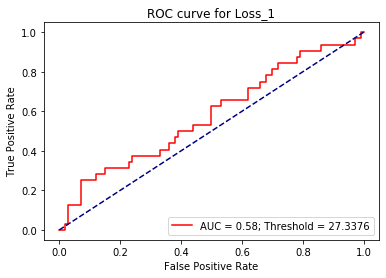

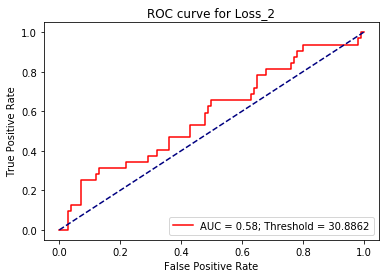

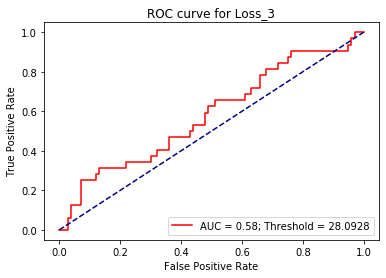

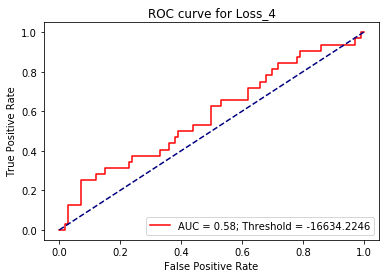

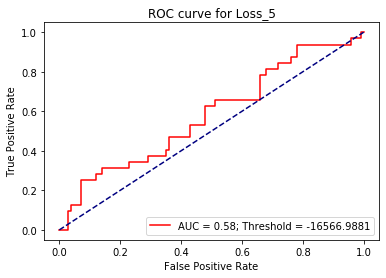

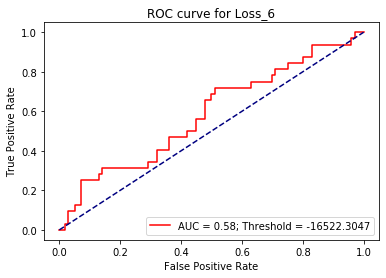

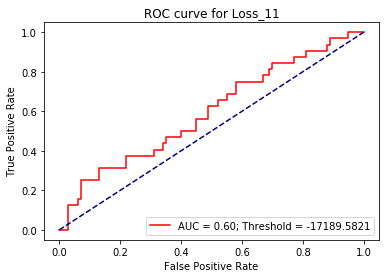

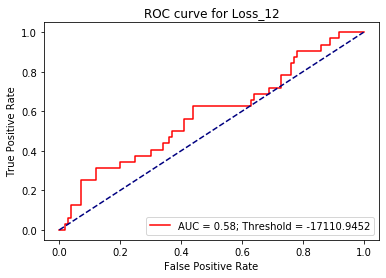

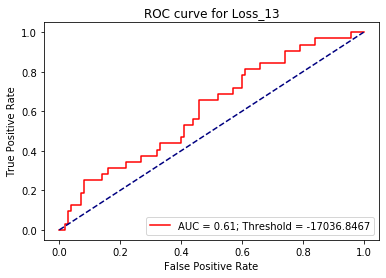

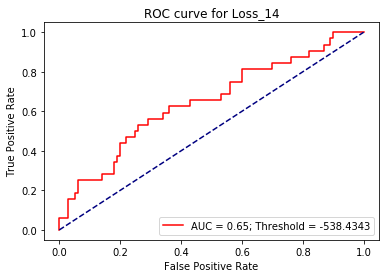

In [25]:
for i in [1, 2, 3, 4, 5, 6, 11, 12, 13, 14]:
    images = load_images(novel_test_path)
    dataset = setup_dataset(images.astype('float32'))
    losses = Loss_functions_dict[i](model, dataset)
    images = load_images(typical_test_path)
    dataset = setup_dataset(images.astype('float32'))
    losses = np.append(losses, Loss_functions_dict[i](model, dataset))
    y_true = np.zeros([len(losses),])
    y_true[0:N_novel_images_test] = 1
    auc_dict[i], threshold_dict[i], _, _, _, threshold_avg_dict[i] = threshold_ROC(y_true, losses, 'Loss_'+str(i), plot=True)
    y_predicted_dict[i] = np.zeros([len(losses),])
    y_predicted_dict[i][np.where(losses > threshold_avg_dict[i])] = 1 

    table_of_counts = np.zeros([2,2])
    for j in range(len(losses),):
      if y_true[j] == 0:
        if y_predicted_dict[i][j] == 0:
          table_of_counts[0,0] += 1
        else: table_of_counts[0,1] += 1
      if y_true[j] == 1:
        if y_predicted_dict[i][j] == 0:
          table_of_counts[1,0] += 1
        else: table_of_counts[1,1] += 1

    true_positive = table_of_counts[1,1]
    false_positive = table_of_counts[0,1]
    true_negative = table_of_counts[0,0]
    false_negative = table_of_counts[1,0]

    accuracy = (true_positive+true_negative)/len(losses)
    avg_accuracy = np.mean([true_positive/(true_positive+false_negative),true_negative/(true_negative+false_positive)])

    table_of_counts_dict[i] = table_of_counts
    accuracy_dict[i] = accuracy
    avg_accuracy_dict[i] = avg_accuracy

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

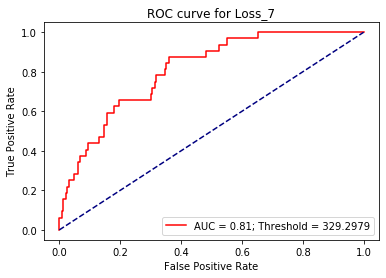

20290.7312541008
[[832. 468.]
 [  5.  27.]]
0.8074038461538462


In [0]:
for i in [7]:
    start_time= time.time()
    temp = np.empty([25,332])
    images = load_images(novel_test_path)
    dataset1 = setup_dataset_no_shuffle(images.astype('float32'))
    for j in range(25):
      print(j, end=' ')
      images = load_images(typical_train_path[4000*j:4000*j+4000])
      dataset2 = setup_dataset_no_shuffle(images.astype('float32'))
      temp[j,:] = Loss_functions_dict[i](model, dataset2, dataset1)
    losses = np.min(temp, axis=0)

    temp = np.empty([25,1000])
    images = load_images(typical_test_path)
    dataset1 = setup_dataset_no_shuffle(images.astype('float32'))
    for j in range(25):
      print(j, end=' ')
      images = load_images(typical_train_path[4000*j:4000*j+4000])
      dataset2 = setup_dataset_no_shuffle(images.astype('float32'))
      temp[j,:] = Loss_functions_dict[i](model, dataset2, dataset1)
    losses = np.append(losses, np.min(temp, axis=0))

    y_true = np.zeros([len(losses),])
    y_true[0:332] = 1
    auc_dict[i], threshold_dict[i], _, _, _, threshold_avg_dict[i] = threshold_ROC(y_true, losses, 'Loss_'+str(i), plot=True)
    y_predicted_dict[i] = np.zeros([len(losses),])
    y_predicted_dict[i][np.where(losses > threshold_dict[i])] = 1 

    table_of_counts = np.zeros([2,2])
    for j in range(len(losses),):
      if y_true[j] == 0:
        if y_predicted_dict[i][j] == 0:
          table_of_counts[0,0] += 1
        else: table_of_counts[0,1] += 1
      if y_true[j] == 1:
        if y_predicted_dict[i][j] == 0:
          table_of_counts[1,0] += 1
        else: table_of_counts[1,1] += 1

    true_positive = table_of_counts[1,1]
    false_positive = table_of_counts[0,1]
    true_negative = table_of_counts[0,0]
    false_negative = table_of_counts[1,0]

    accuracy = (true_positive+true_negative)/len(losses)
    avg_accuracy = np.mean([true_positive/(true_positive+false_negative),true_negative/(true_negative+false_positive)])

    table_of_counts_dict[i] = table_of_counts
    accuracy_dict[i] = accuracy
    avg_accuracy_dict[i] = avg_accuracy
    print(time.time()-start_time)
    print(table_of_counts_dict[i])
    print(auc_dict[i])

In [26]:
print('THRESHOLD METHOD RESULTS')
result_table = np.empty([len(auc_dict),7])
index = ['_']*len(auc_dict)
j = 0
for i in np.sort(list(auc_dict.keys())):
  result_table[j,0] = "{0:.1f}".format(accuracy_dict[i]*100)
  result_table[j,1] = "{0:.1f}".format(avg_accuracy_dict[i]*100)
  result_table[j,2] = table_of_counts_dict[i][1,1].astype('int')
  result_table[j,3] = table_of_counts_dict[i][0,1].astype('int')
  result_table[j,4] = table_of_counts_dict[i][0,0].astype('int')
  result_table[j,5] = table_of_counts_dict[i][1,0].astype('int')
  result_table[j,6] = "{0:.1f}".format(auc_dict[i]*100)
  index[j] = 'Loss_'+str(i)
  j +=1
df = pd.DataFrame(result_table, index=index, columns = ['Accuracy', 'Avg_accuracy', 'True Pos.', 'False Pos.', 'True neg.', 'False Neg.', 'AUC',])
df.astype(str).replace('\.0', '', regex=True)

THRESHOLD METHOD RESULTS


,Accuracy,Avg_accuracy,True Pos.,False Pos.,True neg.,False Neg.,AUC
Loss_1,75.8,57.4,7,7,93,25,58
Loss_2,72.7,57.6,9,13,87,23,58.3
Loss_3,72.7,57.6,9,13,87,23,58.1
Loss_4,75.8,57.4,7,7,93,25,58
Loss_5,75.8,57.4,7,7,93,25,58.2
Loss_6,53.8,58.9,22,51,49,10,58.5
Loss_11,72.7,57.6,9,13,87,23,59.5
Loss_12,73.5,58.1,9,12,88,23,58.3
Loss_13,48.5,58.6,25,61,39,7,60.8
Loss_14,66.7,62.1,17,29,71,15,64.7


In [0]:
def Loss_1_img(model, x):
  losses_per_image = np.empty((0, 64, 64, 6))
  for images in x:
    z_mean, z_logvar = model.encode(images)
    x_logit = model.decode(z_mean)
    pixel_prob = tf.math.sigmoid(x_logit)
    pixel_squared = np.square(pixel_prob - images)
    losses_per_image = np.append(losses_per_image, pixel_squared, axis=0)
  return losses_per_image

def Loss_2_img(model, x):
  losses_per_image = np.empty((0, 64, 64, 6))
  for images in x:
    z_mean, z_logvar = model.encode(images)
    epsilon = tf.random.normal(shape=(30, 768))
    z = epsilon * tf.exp(z_logvar * 0.5) + z_mean
    x_logit = model.decode(z)
    pixel_prob = tf.math.sigmoid(x_logit)
    pixel_squared = np.square(pixel_prob - images)
    losses_per_image = np.append(losses_per_image, np.reshape(np.mean(pixel_squared, axis=0),(1, 64, 64, 6)), axis=0)
  return losses_per_image

def Loss_3_img(model, x):
  losses_per_image = np.empty((0, 64, 64, 6))
  for images in x:
    z_mean, z_logvar = model.encode(images)
    epsilon = tf.random.normal(shape=(30, 768))
    z = epsilon * tf.exp(z_logvar * 0.5) + z_mean
    x_logit = model.decode(z)
    pixel_prob = tf.math.sigmoid(x_logit)
    pixel_squared = np.square(pixel_prob - images)
    losses_per_image = np.append(losses_per_image, np.reshape(np.min(pixel_squared, axis=0),(1, 64, 64, 6)), axis=0)
  return losses_per_image

def Loss_4_img(model, x):
  losses_per_image = np.empty((0, 64, 64, 6))
  for images in x:
    z_mean, z_logvar = model.encode(images)
    x_logit = model.decode(z_mean)
    pixel_prob = tf.math.sigmoid(x_logit)
    logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*images + tf.math.log(1-pixel_prob + 1e-10)*(1-images)
    losses_per_image = np.append(losses_per_image, -logpx_z_pixels, axis=0)
  return losses_per_image

def Loss_5_img(model, x):
  losses_per_image = np.empty((0, 64, 64, 6))
  for images in x:
    z_mean, z_logvar = model.encode(images)
    epsilon = tf.random.normal(shape=(30, 768))
    z = epsilon * tf.exp(z_logvar * 0.5) + z_mean
    x_logit = model.decode(z)
    pixel_prob = tf.math.sigmoid(x_logit)
    logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*images + tf.math.log(1-pixel_prob + 1e-10)*(1-images)
    losses_per_image = np.append(losses_per_image, np.reshape(np.mean(-logpx_z_pixels, axis=0),(1, 64, 64, 6)), axis=0)
  return losses_per_image

def Loss_6_img(model, x):
  losses_per_image = np.empty((0, 64, 64, 6))
  for images in x:
    z_mean, z_logvar = model.encode(images)
    epsilon = tf.random.normal(shape=(30, 768))
    z = epsilon * tf.exp(z_logvar * 0.5) + z_mean
    x_logit = model.decode(z)
    pixel_prob = tf.math.sigmoid(x_logit)
    logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*images + tf.math.log(1-pixel_prob + 1e-10)*(1-images)
    losses_per_image = np.append(losses_per_image, np.reshape(np.min(-logpx_z_pixels, axis=0),(1, 64, 64, 6)), axis=0)
  return losses_per_image

def Loss_7_img(model, x_train, x_test):
  losses_per_image = np.empty([0,64,64,6])
  pixel_prob_per_image_train = np.empty([0,64,64,6])
  pixel_prob_per_image_test = np.empty([0,64,64,6])
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    pixel_prob = tf.math.sigmoid(pixel_prob)
    pixel_prob_per_image_train = np.append(pixel_prob_per_image_train, pixel_prob, axis=0)
    #print(pixel_prob_per_image_train.shape)
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    pixel_prob = tf.math.sigmoid(pixel_prob)
    pixel_prob_per_image_test = np.append(pixel_prob_per_image_test, pixel_prob, axis=0) 
    #print(pixel_prob_per_image_test.shape)
  num = len(pixel_prob_per_image_test)
  for i in range(num):
    temporary = np.abs(pixel_prob_per_image_test[i] - pixel_prob_per_image_train)
    index = tf.reduce_sum(temporary, axis=[1,2,3])
    index = np.argmin(index)
    losses_per_image = np.append(losses_per_image, np.reshape(temporary[index], (1, 64, 64, 6)), axis=0)
  return losses_per_image

def Loss_8(model, x_train, x_test):
  losses_per_image = []
  image_train = []
  pixel_prob_per_image_test = []
  a = 0; b = 0
  for images in x_train:
    if a != 0: image_train = np.append(image_train, images, axis=0)
    else: image_train = images; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if b != 0: pixel_prob_per_image_test = np.append(pixel_prob_per_image_test, pixel_prob, axis=0)
    else: pixel_prob_per_image_test = pixel_prob; b = 1  
  num = len(pixel_prob_per_image_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_9:{}%'.format(100*(i)/num))
    temporary = np.abs(pixel_prob_per_image_test[i] - image_train)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_9(model, x_train, x_test):
  losses_per_image = []
  pixel_prob_per_image_train = []
  image_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if a != 0: pixel_prob_per_image_train = np.append(pixel_prob_per_image_train, pixel_prob, axis=0)
    else: pixel_prob_per_image_train = pixel_prob; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if b != 0: image_test = np.append(image_test, images, axis=0)
    else: image_test = images; b = 1  
  num = len(image_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_10:{}%'.format(100*(i)/num))
    temporary = np.abs(image_test[i] - pixel_prob_per_image_train)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_10(model, x_train, x_test):
  losses_per_image = []
  pixel_prob_per_image_train = []
  pixel_prob_per_image_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if a != 0: pixel_prob_per_image_train = np.append(pixel_prob_per_image_train, pixel_prob, axis=0)
    else: pixel_prob_per_image_train = pixel_prob; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    pixel_prob = model.decode(z_mean)
    if b != 0: pixel_prob_per_image_test = np.append(pixel_prob_per_image_test, pixel_prob, axis=0)
    else: pixel_prob_per_image_test = pixel_prob; b = 1  
  num = len(pixel_prob_per_image_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_8:{}%'.format(100*(i)/num))
    temporary = np.sqrt(np.multiply(1-pixel_prob_per_image_test[i],np.subtract(1,pixel_prob_per_image_train)))+np.sqrt(np.multiply(pixel_prob_per_image_test[i],pixel_prob_per_image_train))
    temporary = np.log(temporary)
    temporary = tf.reduce_sum(temporary, axis=[1,2,3])
    losses_per_image = np.append(losses_per_image, np.min(temporary))
  return losses_per_image

def Loss_11(model, x):
  losses_per_image = Loss_4(model, x)-Loss_14(model, x)
  return losses_per_image

def Loss_12(model, x):
  losses_per_image = Loss_5(model, x)-Loss_14(model, x)
  return losses_per_image

def Loss_13(model, x):
  losses_per_image = Loss_6(model, x)-Loss_14(model, x)
  return losses_per_image

def Loss_14_img(model, x):
  losses_per_image = np.empty((0, z_size))
  for images in x:
    z_mean, z_logvar = model.encode(images)
    KL_parameters = 0.5 * (1 + z_logvar - (z_mean ** 2.0) - tf.exp(z_logvar))
    #KL_vectors = tf.reduce_sum(KL_parameters, axis=1)
    losses_per_image = np.append(losses_per_image, KL_parameters, axis=0)
  return losses_per_image

def Loss_15(model, x_train, x_test):
  losses_per_image = []
  z_mean_per_image_train = []
  z_mean_per_image_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    if a != 0: z_mean_per_image_train = np.append(z_mean_per_image_train, z_mean, axis=0)
    else: z_mean_per_image_train = z_mean; a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    if b != 0: z_mean_per_image_test = np.append(z_mean_per_image_test, z_mean, axis=0)
    else: z_mean_per_image_test = z_mean; b = 1 
  num = len(z_mean_per_image_test)
  for i in range(num):
    if not i%500: clear_output(); print('Progress Loss_15:{}%'.format(100*(i)/num))
    temporary = np.abs(z_mean_per_image_test[i] - z_mean_per_image_train)
    temporary = tf.reduce_sum(temporary, axis=1)
    losses_per_image = np.append(losses_per_image, np.min(temporary)) 
  return losses_per_image

def Loss_16(model, x_train, x_test):
  losses_per_image = []
  z_mean_train = []; z_var_train = []
  z_mean_test = []; z_var_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    if a != 0: 
      z_mean_train = np.append(z_mean_train, z_mean, axis=0)
      z_var_train = np.append(z_var_train, np.exp(z_logvar), axis=0)
    else: 
      z_mean_train = z_mean
      z_var_train = np.exp(z_logvar)
      a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    if b != 0: 
      z_mean_test = np.append(z_mean_test, z_mean, axis=0)
      z_var_test = np.append(z_var_test, np.exp(z_logvar), axis=0)
    else: 
      z_mean_test = z_mean
      z_var_test = np.exp(z_logvar)
      b = 1 
  num = len(z_mean_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_16:{}%'.format(100*(i)/num))
    temporary_1 = np.log(np.multiply(0.25, (np.add(np.divide(z_var_test[i], z_var_train), np.add(np.divide(z_var_train, z_var_test[i]),2)))))
    temporary_2 = np.divide(np.square(np.subtract(z_mean_test[i], z_mean_train)), np.add(z_var_test[i], z_var_train))
    temporary = np.multiply(0.25, temporary_1) + np.multiply(0.25, temporary_2)
    losses_per_image = np.append(losses_per_image, np.min(np.sum(temporary)))
  return losses_per_image

def Loss_17(model, x_train, x_test):
  losses_per_image = []
  z_mean_train = []; z_var_train = []
  z_mean_test = []
  a = 0; b = 0
  for images in x_train:
    z_mean, z_logvar = model.encode(images)
    if a != 0:
      z_mean_train = np.append(z_mean_train, z_mean, axis=0)
      z_var_train = np.append(z_var_train, np.exp(z_logvar), axis=0)
    else: 
      z_mean_train = z_mean
      z_var_train = np.exp(z_logvar)
      a = 1
  for images in x_test:
    z_mean, z_logvar = model.encode(images)
    if b != 0: z_mean_test = np.append(z_mean_test, z_mean, axis=0)
    else: z_mean_test = z_mean; b = 1 
  
  num = len(z_mean_test)
  for i in range(num):
    if not i%100: clear_output(); print('Progress Loss_17:{}%'.format(100*(i)/num))
    A = np.divide(0.39894, np.sqrt(z_var_train))
    B1 = np.subtract(z_mean_test[i], z_mean_train)
    B2 = np.sqrt(z_var_train)
    B = np.multiply(-0.5, np.square(np.divide(B1,B2)))
    temporary = np.multiply(A, np.exp(B))
    temporary = np.mean(temporary)
    losses_per_image = np.append(losses_per_image, temporary) 
  return -losses_per_image

Loss_functions_img_dict = dict([(1,Loss_1_img),(2,Loss_2_img),(3,Loss_3_img),(4,Loss_4_img),(5,Loss_5_img),(6,Loss_6_img),(7,Loss_7_img),
                                (8,Loss_8),(9,Loss_9),(10,Loss_10),(11,Loss_11),(12,Loss_12),(13,Loss_13),
                                (14,Loss_14_img),(15,Loss_15),(16,Loss_16),(17,Loss_17)])

In [0]:
os.mkdir('/content/error_map_typical_train/')
os.mkdir('/content/error_map_typical_test/')
os.mkdir('/content/error_map_novel_train/')
os.mkdir('/content/error_map_novel_test/')

# RECONSTRUCTION LOSSES

In [0]:
os.mkdir('/content/error_map_typical_train_1/')

In [0]:
time1 = time.time()

typical_1 = shuffle(typical_train_path[0:47800])
typical_2 = shuffle(typical_train_path[47800:97800])

print('Progress of error_map_typical_train_1')
for i in range(len(typical_1)):
    if i%(len(typical_1)/100*5) == 0: print(str(int(i/len(typical_1)*100)) + '%,', end = ' ')
    images = load_images(typical_1[i])
    images = (images/255).astype('float32')
    z_mean, z_logvar = model.encode(images)
    x_logit = model.decode(z_mean)
    pixel_prob = tf.math.sigmoid(x_logit)
    pixel_prob = np.squeeze(pixel_prob).astype('float32')
    np.save('/content/error_map_typical_train_1/'+str(i), pixel_prob)
print('100%')

print('\nProgress of error_map_typical_train')
for i in range(len(typical_2)):
    if i%(len(typical_2)/100*5) == 0: print(str(int(i/len(typical_2)*100)) + '%,', end = ' ')
    images = load_images(typical_2[i])
    images = (images/255).astype('float32')
    z_mean, z_logvar = model.encode(images)
    x_logit = model.decode(z_mean)
    pixel_prob = tf.math.sigmoid(x_logit)
    pixel_prob = np.squeeze(pixel_prob).astype('float32')
    np.save('/content/error_map_typical_train/'+str(i), pixel_prob)
print('100%')

print('\nProgress of error_map_typical_test')
for i in range(len(typical_test_path)):
    if i%100 == 0: print(str(i/1000*100) + '%,', end = ' ')
    images = load_images(typical_test_path[i])
    images = (images/255).astype('float32')
    z_mean, z_logvar = model.encode(images)
    x_logit = model.decode(z_mean)
    pixel_prob = tf.math.sigmoid(x_logit)
    pixel_prob = np.squeeze(pixel_prob).astype('float32')
    np.save('/content/error_map_typical_test/'+str(i), pixel_prob)
print('100%')

print('\nProgress of error_map_novel_train')
for i in range(len(novel_train_path)):
    if i%17 == 0: print(str(i/170*100) + '%,', end = ' ')
    images = load_images(novel_train_path[i])
    images = (images/255).astype('float32')
    z_mean, z_logvar = model.encode(images)
    x_logit = model.decode(z_mean)
    pixel_prob = tf.math.sigmoid(x_logit)
    pixel_prob = np.squeeze(pixel_prob).astype('float32')
    np.save('/content/error_map_novel_train/'+str(i), pixel_prob)
print('100%')

print('\nProgress of error_map_novel_test')
for i in range(len(novel_test_path)):
    if i%17 == 0: print(str(i/170*100) + '%,', end = ' ')
    images = load_images(novel_test_path[i])
    images = (images/255).astype('float32')
    z_mean, z_logvar = model.encode(images)
    x_logit = model.decode(z_mean)
    pixel_prob = tf.math.sigmoid(x_logit)
    pixel_prob = np.squeeze(pixel_prob).astype('float32')
    np.save('/content/error_map_novel_test/'+str(i), pixel_prob)
print('100%')

print(time.time()-time1)

Progress of error_map_typical_train_1
0%, 5%, 10%, 15%, 20%, 25%, 30%, 35%, 40%, 45%, 50%, 55%, 60%, 65%, 70%, 75%, 80%, 85%, 90%, 95%, 100%

Progress of error_map_typical_train
0%, 5%, 10%, 15%, 20%, 25%, 30%, 35%, 40%, 45%, 50%, 55%, 60%, 65%, 70%, 75%, 80%, 85%, 90%, 95%, 100%

Progress of error_map_typical_test
0.0%, 10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100%

Progress of error_map_novel_train
0.0%, 10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100%

Progress of error_map_novel_test
0.0%, 10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100%
937.223007440567


In [0]:
time1 = time.time()
for i in range(1):
  print(i)
  a = load_images(errormap_typical_test_path[0:1000])
  diff = np.zeros([1000, len(errormap_typical_train_path)])
  for j in range(5):
    b = load_images(errormap_typical_train_path[j*10000:(j+1)*10000])
    for k in range(1000):
      temp = tf.square(np.reshape(a[k], (1,64,64,6))-b)
      diff[k, j*10000:(j+1)*10000] = tf.reduce_sum(temp, axis=(1,2,3))
  index = np.argmin(diff, axis=1)
  print(index)
print(time.time()-time1)

In [0]:
errormap_typical_train_1_path = []
errormap_typical_train_path = []
errormap_typical_test_path = []
errormap_novel_train_path = []
errormap_novel_test_path = []

for i in range(len(typical_1)):
  errormap_typical_train_1_path.append('/content/error_map_typical_train_1/'+str(i)+'.npy')

for i in range(len(typical_2)):
  errormap_typical_train_path.append('/content/error_map_typical_train/'+str(i)+'.npy')

for i in range(len(typical_test_path)):
  errormap_typical_test_path.append('/content/error_map_typical_test/'+str(i)+'.npy')

for i in range(len(novel_train_path)):
  errormap_novel_train_path.append('/content/error_map_novel_train/'+str(i)+'.npy')

for i in range(len(novel_test_path)):
  errormap_novel_test_path.append('/content/error_map_novel_test/'+str(i)+'.npy')

print('losses_typical_img_train_1 = ' + str(len(errormap_typical_train_1_path)))
print('losses_typical_img_train = ' + str(len(errormap_typical_train_path)))
print('losses_novel_img_train   = ' + str(len(errormap_typical_test_path)))
print('losses_typical_img_test  = ' + str(len(errormap_novel_train_path)))
print('losses_novel_img_test    = ' + str(len(errormap_novel_test_path)))

losses_typical_img_train = 47800
losses_typical_img_train = 50000
losses_novel_img_train   = 1000
losses_typical_img_test  = 166
losses_novel_img_test    = 166


In [324]:
loss_num = 4
time1 = time.time()

print('Progress of error_map_typical_train')
for i in range(len(typical_train_path)):
    if i%(len(typical_train_path)/100*5) == 0: print(str(int(i/len(typical_train_path)*100)) + '%,', end = ' ')
    images = load_images(typical_train_path[i])
    dataset = setup_dataset(images.astype('float32'))
    loss = Loss_functions_img_dict[loss_num](model, dataset)
    loss = np.squeeze(loss).astype('float32')
    np.save('/content/error_map_typical_train/'+str(i), loss)
print('100%')

print('\nProgress of error_map_typical_test')
for i in range(len(typical_test_path)):
    if i%100 == 0: print(str(i/1000*100) + '%,', end = ' ')
    images = load_images(typical_test_path[i])
    dataset = setup_dataset(images.astype('float32'))
    loss = Loss_functions_img_dict[loss_num](model, dataset)
    loss = np.squeeze(loss).astype('float32')
    np.save('/content/error_map_typical_test/'+str(i), loss)
print('100%')

print('\nProgress of error_map_novel_train')
for i in range(len(novel_train_path)):
    if i%17 == 0: print(str(i/170*100) + '%,', end = ' ')
    images = load_images(novel_train_path[i])
    dataset = setup_dataset(images.astype('float32'))
    loss = Loss_functions_img_dict[loss_num](model, dataset)
    loss = np.squeeze(loss).astype('float32')
    np.save('/content/error_map_novel_train/'+str(i), loss)
print('100%')

print('\nProgress of error_map_novel_test')
for i in range(len(novel_test_path)):
    if i%17 == 0: print(str(i/170*100) + '%,', end = ' ')
    images = load_images(novel_test_path[i])
    dataset = setup_dataset(images.astype('float32'))
    loss = Loss_functions_img_dict[loss_num](model, dataset)
    loss = np.squeeze(loss).astype('float32')
    np.save('/content/error_map_novel_test/'+str(i), loss)
print('100%')

print(time.time()-time1)

Progress of error_map_typical_train
0%, 5%, 10%, 15%, 20%, 25%, 30%, 35%, 40%, 45%, 50%, 55%, 60%, 65%, 70%, 75%, 80%, 85%, 90%, 95%, 100%

Progress of error_map_typical_test
0.0%, 100%

Progress of error_map_novel_train
0.0%, 10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100.0%, 110.00000000000001%, 120.0%, 130.0%, 140.0%, 150.0%, 160.0%, 170.0%, 100%

Progress of error_map_novel_test
0.0%, 10.0%, 100%
1260.638031721115


In [0]:
errormap_typical_train_path = []
errormap_typical_test_path = []
errormap_novel_train_path = []
errormap_novel_test_path = []

for i in range(len(typical_train_path)):
  errormap_typical_train_path.append('/content/error_map_typical_train/'+str(i)+'.npy')

for i in range(len(typical_test_path)):
  errormap_typical_test_path.append('/content/error_map_typical_test/'+str(i)+'.npy')

for i in range(len(novel_train_path)):
  errormap_novel_train_path.append('/content/error_map_novel_train/'+str(i)+'.npy')

for i in range(len(novel_test_path)):
  errormap_novel_test_path.append('/content/error_map_novel_test/'+str(i)+'.npy')

CHECK LEN
losses_typical_img_train = 98700
losses_novel_img_train   = 100
losses_typical_img_test  = 300
losses_novel_img_test    = 32

TYPICAL IMAGE 0:
Original Pictures:


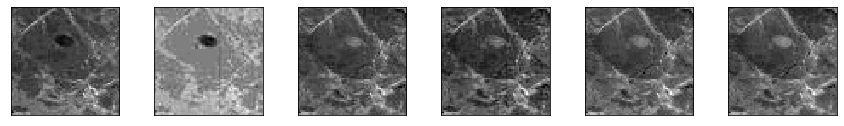

Reconstructed Pictures


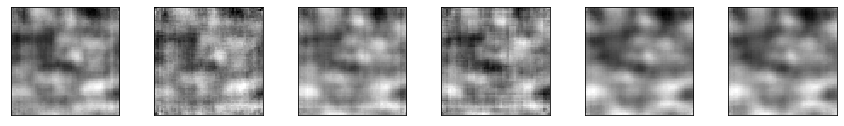

Error Map


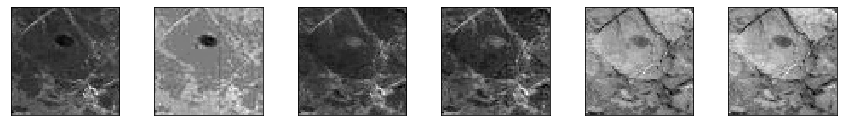

14870.17

NOVEL IMAGE 0:
Original Pictures:


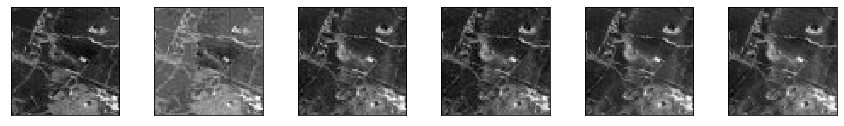

Reconstructed Pictures


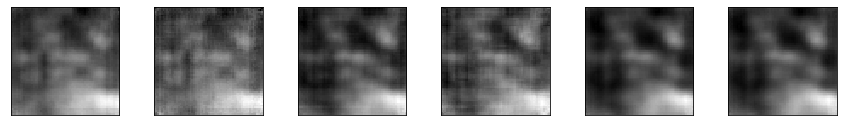

Error Map


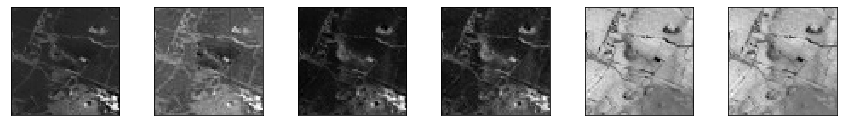

14829.84


In [414]:
print('CHECK LEN')
print('losses_typical_img_train = ' + str(len(errormap_typical_train_path)))
print('losses_novel_img_train   = ' + str(len(errormap_typical_test_path)))
print('losses_typical_img_test  = ' + str(len(errormap_novel_train_path)))
print('losses_novel_img_test    = ' + str(len(errormap_novel_test_path)))

i = 0
print('\nTYPICAL IMAGE ' + str(i) + ':')
reconstruct_images(typical_train_path[i])
print('Error Map')
plot_image(load_images(errormap_typical_train_path[i]))
print(np.sum(load_images(errormap_typical_train_path[i])))

i = 0
print('\nNOVEL IMAGE ' + str(i) + ':')
reconstruct_images(novel_train_path[i])
print('Error Map')
plot_image(load_images(errormap_novel_train_path[i]))
print(np.sum(load_images(errormap_novel_train_path[i])))

In [0]:
def setup_dataset(x, y):
  images = x

  batch_size = 100
  dataset = tf.data.Dataset.from_tensor_slices((images, y)).shuffle(len(images)).batch(batch_size)
  return dataset

def setup_dataset_no_shuffle(x, y):
  images = x

  batch_size = 100
  dataset = tf.data.Dataset.from_tensor_slices((images, y)).batch(batch_size)
  return dataset

In [416]:
class classifier_model(tf.keras.Model):
    def __init__(self):
        super(classifier_model, self).__init__()
        self.classifier_nn = tf.keras.models.Sequential([
                             tf.keras.layers.Input(shape = (64, 64, 6)) ,                        
                             tf.keras.layers.Conv2D(32, (5,5), padding='SAME', activation='relu'),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
                             tf.keras.layers.Conv2D(64, (5,5), padding='SAME', activation='relu'),
                             tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(512, activation='relu'),
                             tf.keras.layers.Dropout(rate=0.4),
                             tf.keras.layers.Dense(1)
                             ], name='Classifier')

    def classify(self, x):
        logits = self.classifier_nn(x)
        prob   = tf.math.sigmoid(logits)
        return logits, prob

classifier = classifier_model()
classifier.classifier_nn.summary()

Model: "Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_80 (Conv2D)           (None, 64, 64, 32)        4832      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 32, 32, 64)        51264     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_57 (Flatten)         (None, 16384)             0         
_________________________________________________________________
dense_229 (Dense)            (None, 512)               8389120   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00009) #0.0001
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [0]:
def train_step(model, x, y, optimizer):
    with tf.GradientTape() as tape:
        loss = calculate_loss(model, x, y)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)

def test_step(model, x, y, optimizer):
    loss = calculate_loss(model, x)
    test_loss(loss)

def train_only_dataset(model, train_dataset, epochs):  
  for epoch in range(epochs):
    for train_x, train_y in train_dataset: 
      
      train_step(model, train_x, train_y, optimizer)
      
    loss = train_loss.result()
     
  train_loss.reset_states()
  return loss

### Classify using error maps, imbalanced set (__)


In [0]:
def calculate_loss(model, x, y):
    logits, prob = model.classify(x)
    labels = y

    weight = len(errormap_typical_train_path)/len(errormap_novel_train_path)
      
    loss = tf.nn.weighted_cross_entropy_with_logits(labels = labels, logits = logits, pos_weight = weight)
    loss = tf.reduce_mean(loss)

    return loss

In [0]:
classifier = classifier_model()
#classifier.classifier_nn.load_weights('/content/drive/My Drive/SPACE_DATA/Novelty_Classifier_Imbalanced/')

4.97---> 0.8981532


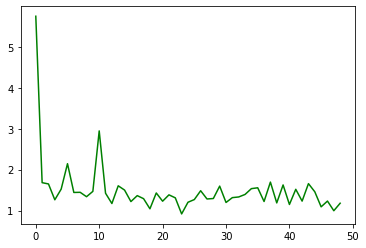

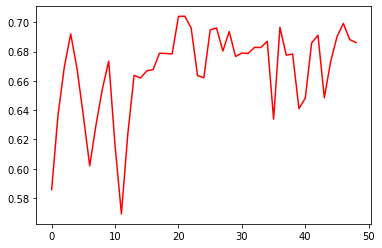

TRAINING TIME = 1829.7032625675201



In [0]:
start_time = time.time()

losses = []
train_data = np.append(errormap_novel_train_path, errormap_typical_train_path)
train_labels = np.zeros([len(train_data), 1]).astype('float32')
train_labels[0:166, 0] = 1

losses_test = []
test_data = np.append(errormap_novel_test_path, errormap_typical_test_path)
test_labels = np.zeros([len(test_data), 1]).astype('float32')
test_labels[0:166, 0] = 1

epochs = 5

for j in range(epochs):

  train_data, train_labels = shuffle(train_data, train_labels, random_state=0)

  for i in range(98):

    dataset = setup_dataset(load_images(train_data[i*1000:(i+1)*1000]), train_labels[i*1000:(i+1)*1000])
    loss = train_only_dataset(classifier, dataset, 1)
    losses = np.append(losses, loss.numpy())

    logits, _ = classifier.classify(load_images(test_data))
    logits = np.array(logits[:,0])
    _, _, _, _, l, _ = threshold_ROC(test_labels, logits, 'NN classifier', plot=False)
    losses_test = np.append(losses_test, l)

    if len(losses)%10 == 0 and i>1:
      clear_output()
      print(str(j) + '.' + str(i) + '---> ' + str(loss.numpy()))

      a = np.reshape(losses, [-1,10])
      a = np.mean(a, axis=1)
      plt.plot(range(len(a)), a, color='green')
      plt.show()

      b = np.reshape(losses_test, [-1,10])
      b = np.mean(b, axis=1)
      plt.plot(range(len(b)), b, color='red')
      plt.show()

  #classifier.classifier_nn.save_weights('/content/drive/My Drive/SPACE_DATA/Novelty_Classifier_Imbalanced/')

print('TRAINING TIME = {}\n'.format(time.time()-start_time))

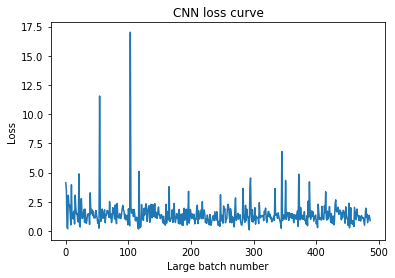

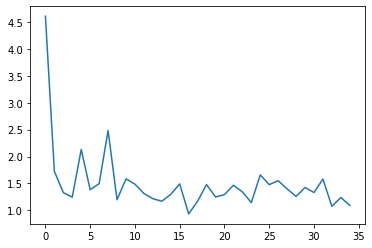

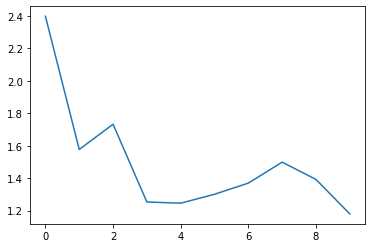

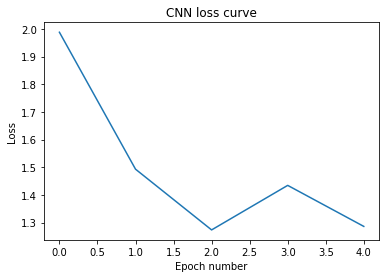

In [0]:
l = losses

plt.plot(range(len(l[2:-1])), l[2:-1])
plt.title('CNN loss curve')
plt.xlabel('Large batch number')
plt.ylabel('Loss')
plt.savefig('/content/ROC_losses_graph/loss_curve_imbalance')
plt.show()

a = np.reshape(l, [-1,14])
a = np.mean(a, axis=1)
plt.plot(range(len(a)), a)
plt.show()

a = np.reshape(l, [-1,49])
a = np.mean(a, axis=1)
plt.plot(range(len(a)), a)
plt.show()

a = np.reshape(l, [-1,98])
a = np.mean(a, axis=1)
plt.plot(range(len(a)), a)
plt.title('CNN loss curve')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.savefig('/content/ROC_losses_graph/loss_curve_imbalance_epoch')
plt.show()

In [0]:
test_data = np.append(errormap_novel_test_path, errormap_typical_test_path)
y_true = np.zeros([len(test_data),]).astype('int')
y_true[0:166] = 1
test_data, y_true = shuffle(test_data, y_true, random_state=0)

test_images = load_images(test_data)
logits, prob = classifier.classify(test_images)
logits = np.array(logits[:,0])

print(logits)

[-16.857523    -3.861118    -0.26967356 ...  -0.8316741   -6.9116845
  -0.47629786]


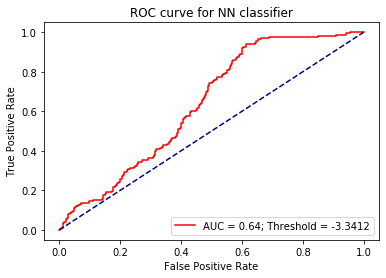

,Accuracy,Avg_accuracy,True Pos.,False Pos.,True Neg.,False Neg.,AUC
0,46.3,65.9,155,615,385,11,63.7


In [0]:
auc_value, threshold_value, _, _, _, threshold_avg_value = threshold_ROC(y_true, logits, 'NN classifier', plot=True)
y_predicted = np.zeros([len(y_true),])
y_predicted[np.where(logits > threshold_avg_value)] = 1 

table_of_counts = np.zeros([2,2])
for j in range(len(y_true),):
  if y_true[j] == 0:
    if y_predicted[j] == 0:
      table_of_counts[0,0] += 1
    else: table_of_counts[0,1] += 1
  if y_true[j] == 1:
    if y_predicted[j] == 0:
      table_of_counts[1,0] += 1
    else: table_of_counts[1,1] += 1

true_positive = table_of_counts[1,1]
false_positive = table_of_counts[0,1]
true_negative = table_of_counts[0,0]
false_negative = table_of_counts[1,0]

accuracy = (true_positive+true_negative)/len(y_true)
avg_accuracy = np.mean([true_positive/(true_positive+false_negative),true_negative/(true_negative+false_positive)])

result_table = np.empty([1,7])
index = ['_']*1
result_table[0,0] = "{0:.1f}".format(accuracy*100)
result_table[0,1] = "{0:.1f}".format(avg_accuracy*100)
result_table[0,2] = table_of_counts[1,1].astype('int')
result_table[0,3] = table_of_counts[0,1].astype('int')
result_table[0,4] = table_of_counts[0,0].astype('int')
result_table[0,5] = table_of_counts[1,0].astype('int')
result_table[0,6] = "{0:.1f}".format(auc_value*100)
index = 'Loss_1'
df = pd.DataFrame(result_table, columns = ['Accuracy', 'Avg_accuracy', 'True Pos.', 'False Pos.', 'True Neg.', 'False Neg.','AUC'])
df.astype(str).replace('\.0', '', regex=True)

In [0]:
classifier.classifier_nn.save_weights('/content/drive/My Drive/SPACE_DATA/Novelty_Classifier_Imbalanced/')

### Classify using error maps, balanced set 6 (83.4, 73.5)

In [0]:
def calculate_loss(model, x, y):
    logits, prob = model.classify(x)
    labels = y

    weight = 1000/166
      
    loss = tf.nn.weighted_cross_entropy_with_logits(labels = labels, logits = logits, pos_weight = weight)
    loss = tf.reduce_mean(loss)

    return loss

In [0]:
classifier = classifier_model()
#classifier.classifier_nn.load_weights('/content/drive/My Drive/SPACE_DATA/Novelty_Classifier_Balanced_6/')

In [0]:
start_time = time.time()

losses = []

losses_test = []
test_data = np.append(errormap_novel_test_path, errormap_typical_test_path)
test_labels = np.zeros([len(test_data), 1]).astype('float32')
test_labels[0:166, 0] = 1

epochs = 5

for j in range(epochs):

  train_data, train_labels = shuffle(train_data, train_labels, random_state=0)

  for i in range(98):
    
    train_data = np.append(errormap_novel_train_path, errormap_typical_train_path[i*1000:(i+1)*1000])
    train_labels = np.zeros([len(train_data), 1]).astype('float32')
    train_labels[0:166, 0] = 1
    dataset = setup_dataset(load_images(train_data), train_labels)
    loss = train_only_dataset(classifier, dataset, 1)
    losses = np.append(losses, loss.numpy())

    logits, _ = classifier.classify(load_images(test_data))
    logits = np.array(logits[:,0])
    _, _, _, _, l, _ = threshold_ROC(test_labels, logits, 'NN classifier', plot=False)
    losses_test = np.append(losses_test, l)

    if len(losses)%10 == 0 and i>1:
      clear_output()
      print(str(j) + '.' + str(i) + '---> ' + str(loss.numpy()))

      a = np.reshape(losses, [-1,10])
      a = np.mean(a, axis=1)
      plt.plot(range(len(a)), a, color='green')
      plt.show()

      b = np.reshape(losses_test, [-1,10])
      b = np.mean(b, axis=1)
      plt.plot(range(len(b)), b, color='red')
      plt.show()

  #classifier.classifier_nn.save_weights('/content/drive/My Drive/SPACE_DATA/Novelty_Classifier/')

print('TRAINING TIME = {}\n'.format(time.time()-start_time))

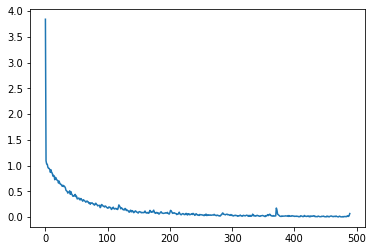

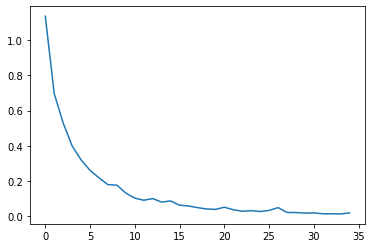

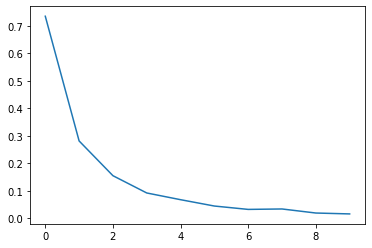

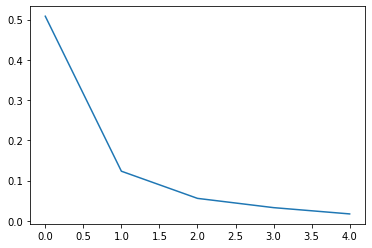

In [0]:
l = losses

plt.plot(range(len(l)), l)
plt.show()

a = np.reshape(l, [-1,14])
a = np.mean(a, axis=1)
plt.plot(range(len(a)), a)
plt.show()

a = np.reshape(l, [-1,49])
a = np.mean(a, axis=1)
plt.plot(range(len(a)), a)
plt.show()

a = np.reshape(l, [-1,98])
a = np.mean(a, axis=1)
plt.plot(range(len(a)), a)
plt.show()

In [0]:
test_data = np.append(errormap_novel_test_path, errormap_typical_test_path)
y_true = np.zeros([len(test_data),]).astype('int')
y_true[0:166] = 1
test_data, y_true = shuffle(test_data, y_true, random_state=0)

test_images = load_images(test_data)
logits, prob = classifier.classify(test_images)
logits = np.array(logits[:,0])

print(logits)

[-267.47986   -81.5572    -13.17703  ...  -21.700806  -46.924934
  -16.2359  ]


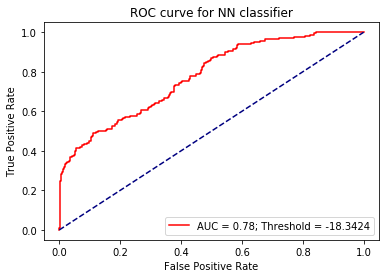

,Accuracy,Avg_accuracy,True Pos.,False Pos.,True Neg.,False Neg.,AUC
0,83,68.5,80,112,888,86,77.5


In [0]:
auc_value, threshold_value, _, _, _, threshold_avg_value = threshold_ROC(y_true, logits, 'NN classifier', plot=True)
y_predicted = np.zeros([len(y_true),])
y_predicted[np.where(logits > threshold_avg_value)] = 1 

table_of_counts = np.zeros([2,2])
for j in range(len(y_true),):
  if y_true[j] == 0:
    if y_predicted[j] == 0:
      table_of_counts[0,0] += 1
    else: table_of_counts[0,1] += 1
  if y_true[j] == 1:
    if y_predicted[j] == 0:
      table_of_counts[1,0] += 1
    else: table_of_counts[1,1] += 1

true_positive = table_of_counts[1,1]
false_positive = table_of_counts[0,1]
true_negative = table_of_counts[0,0]
false_negative = table_of_counts[1,0]

accuracy = (true_positive+true_negative)/len(y_true)
avg_accuracy = np.mean([true_positive/(true_positive+false_negative),true_negative/(true_negative+false_positive)])

result_table = np.empty([1,7])
index = ['_']*1
result_table[0,0] = "{0:.1f}".format(accuracy*100)
result_table[0,1] = "{0:.1f}".format(avg_accuracy*100)
result_table[0,2] = table_of_counts[1,1].astype('int')
result_table[0,3] = table_of_counts[0,1].astype('int')
result_table[0,4] = table_of_counts[0,0].astype('int')
result_table[0,5] = table_of_counts[1,0].astype('int')
result_table[0,6] = "{0:.1f}".format(auc_value*100)
index = 'Loss_1'
df = pd.DataFrame(result_table, columns = ['Accuracy', 'Avg_accuracy', 'True Pos.', 'False Pos.', 'True Neg.', 'False Neg.','AUC'])
df.astype(str).replace('\.0', '', regex=True)

In [0]:
#classifier.classifier_nn.save_weights('/content/drive/My Drive/SPACE_DATA/Novelty_Classifier_Balanced_6/')

### Classify using error maps, balanced set 12 (81.5, 74.4)

In [0]:
def calculate_loss(model, x, y):
    logits, prob = model.classify(x)
    labels = y

    weight = 1000/83
      
    loss = tf.nn.weighted_cross_entropy_with_logits(labels = labels, logits = logits, pos_weight = weight)
    loss = tf.reduce_mean(loss)

    return loss

In [0]:
classifier = classifier_model()
#classifier.classifier_nn.load_weights('/content/drive/My Drive/SPACE_DATA/Novelty_Classifier_Balanced_12/')

9.97---> 1.769566


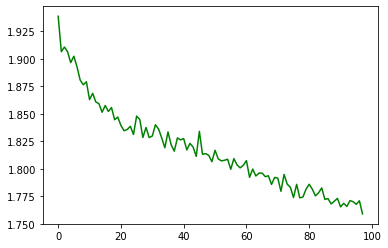

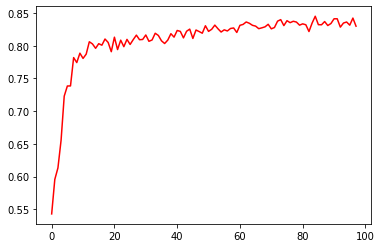

TRAINING TIME = 3726.101014137268



In [424]:
start_time = time.time()

losses = []

losses_test = []
test_data = np.append(errormap_novel_test_path, errormap_typical_test_path)
test_labels = np.zeros([len(test_data), 1]).astype('float32')
test_labels[0:N_novel_images_test, 0] = 1

epochs = 10

for j in range(epochs):

  typical = shuffle(errormap_typical_train_path)

  for i in range(98):
    novel = shuffle(errormap_novel_train_path)
    train_data = np.append(novel[0:83], typical[i*1000:(i+1)*1000])
    train_labels = np.zeros([len(train_data), 1]).astype('float32')
    train_labels[0:N_novel_images_train, 0] = 1
    dataset = setup_dataset(load_images(train_data), train_labels)
    loss = train_only_dataset(classifier, dataset, 1)
    losses = np.append(losses, loss.numpy())

    logits, _ = classifier.classify(load_images(test_data))
    logits = np.array(logits[:,0])
    _, _, _, _, l, _ = threshold_ROC(test_labels, logits, 'NN classifier', plot=False)
    losses_test = np.append(losses_test, l)

    if len(losses)%10 == 0 and i>1:
      clear_output()
      print(str(j) + '.' + str(i) + '---> ' + str(loss.numpy()))

      a = np.reshape(losses, [-1,10])
      a = np.mean(a, axis=1)
      plt.plot(range(len(a)), a, color='green')
      plt.show()

      b = np.reshape(losses_test, [-1,10])
      b = np.mean(b, axis=1)
      plt.plot(range(len(b)), b, color='red')
      plt.show()

  #classifier.classifier_nn.save_weights('/content/drive/My Drive/SPACE_DATA/Novelty_Classifier/')

print('TRAINING TIME = {}\n'.format(time.time()-start_time))

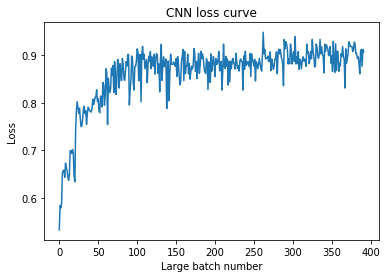

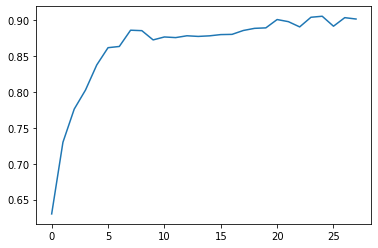

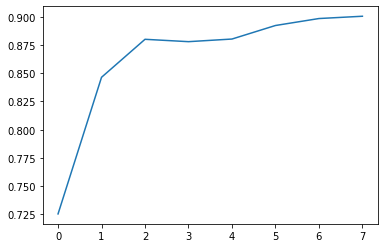

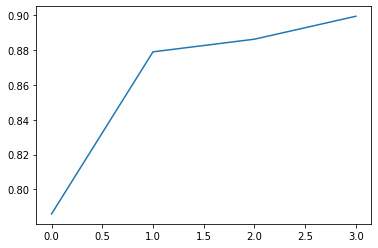

In [0]:
l = losses_test

plt.plot(range(len(l)), l)
plt.title('CNN loss curve')
plt.xlabel('Large batch number')
plt.ylabel('Loss')
plt.savefig('/content/ROC_losses_graph/loss_curve_12')
plt.show()

a = np.reshape(l, [-1,14])
a = np.mean(a, axis=1)
plt.plot(range(len(a)), a)
plt.show()

a = np.reshape(l, [-1,49])
a = np.mean(a, axis=1)
plt.plot(range(len(a)), a)
plt.show()

a = np.reshape(l, [-1,98])
a = np.mean(a, axis=1)
plt.plot(range(len(a)), a)
plt.show()

In [0]:
test_data = np.append(errormap_novel_test_path, errormap_typical_test_path)
y_true = np.zeros([len(test_data),]).astype('int')
y_true[0:N_novel_images_test] = 1
test_data, y_true = shuffle(test_data, y_true, random_state=0)

test_images = load_images(test_data)
logits, prob = classifier.classify(test_images)
logits = np.array(logits[:,0])
prob = np.array(prob[:,0])

#print(logits)
print(prob)

[0.8140702  0.75283265 0.8936474  0.92449194 0.934599   0.795879
 0.79317415 0.8653815  0.8165076  0.79258883 0.8341937  0.7626992
 0.8389724  0.80254954 0.9670514  0.8429499  0.8274367  0.7733558
 0.9708055  0.9356895  0.78398806 0.90848696 0.82146376 0.80109453
 0.98276377 0.8616568  0.8305015  0.8197881  0.88505447 0.8301075
 0.79429954 0.8146661  0.79847854 0.81085163 0.82431054 0.9784172
 0.8056335  0.8663822  0.8035543  0.78132385 0.94081664 0.845935
 0.8412018  0.8406092  0.79727644 0.8371972  0.7927721  0.8088971
 0.7934149  0.7863473  0.8242579  0.79179597 0.75611395 0.78495395
 0.85356456 0.7436166  0.9841764  0.8923913  0.79727113 0.8346609
 0.8205261  0.8402783  0.82020766 0.8736993  0.89373726 0.83912027
 0.9174776  0.8315681  0.81547344 0.8422808  0.9741417  0.9323754
 0.7747676  0.9697129  0.76346874 0.8088636  0.7922641  0.97846985
 0.7694142  0.8996118  0.813776   0.6708269  0.8008297  0.76961106
 0.82660156 0.93296134 0.7656031  0.78428215 0.82042456 0.8217118
 0.8063

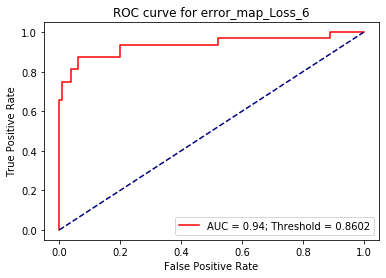

,Accuracy,Avg_accuracy,True Pos.,False Pos.,True Neg.,False Neg.,AUC
0,91.7,89.2,27,6,94,5,93.6


In [0]:
auc_value, threshold_value, _, _, _, threshold_avg_value = threshold_ROC(y_true, prob, 'error_map_Loss_'+str(loss_num), plot=True)
y_predicted = np.zeros([len(y_true),])
y_predicted[np.where(prob > threshold_avg_value)] = 1 

table_of_counts = np.zeros([2,2])
for j in range(len(y_true),):
  if y_true[j] == 0:
    if y_predicted[j] == 0:
      table_of_counts[0,0] += 1
    else: table_of_counts[0,1] += 1
  if y_true[j] == 1:
    if y_predicted[j] == 0:
      table_of_counts[1,0] += 1
    else: table_of_counts[1,1] += 1

true_positive = table_of_counts[1,1]
false_positive = table_of_counts[0,1]
true_negative = table_of_counts[0,0]
false_negative = table_of_counts[1,0]

accuracy = (true_positive+true_negative)/len(y_true)
avg_accuracy = np.mean([true_positive/(true_positive+false_negative),true_negative/(true_negative+false_positive)])

result_table = np.empty([1,7])
index = ['_']*1
result_table[0,0] = "{0:.1f}".format(accuracy*100)
result_table[0,1] = "{0:.1f}".format(avg_accuracy*100)
result_table[0,2] = table_of_counts[1,1].astype('int')
result_table[0,3] = table_of_counts[0,1].astype('int')
result_table[0,4] = table_of_counts[0,0].astype('int')
result_table[0,5] = table_of_counts[1,0].astype('int')
result_table[0,6] = "{0:.1f}".format(auc_value*100)
index = 'Loss_1'
df = pd.DataFrame(result_table, columns = ['Accuracy', 'Avg_accuracy', 'True Pos.', 'False Pos.', 'True Neg.', 'False Neg.','AUC'])
df.astype(str).replace('\.0', '', regex=True)

In [0]:
#classifier.classifier_nn.save_weights('/content/drive/My Drive/SPACE_DATA/Novelty_Classifier_Balanced_12_loss6/')

# LATENT SPACE LOSSES

### Losses 15, 16, 17

In [0]:
os.mkdir('/content/error_map_typical_train_1/')

In [0]:
typical_1 = shuffle(typical_train_path[0:50000])
typical_2 = shuffle(typical_train_path[50000:98700])

In [0]:
time1 = time.time()

print('Progress of error_map_typical_train_1')
for i in range(len(typical_1)):
    if i%(len(typical_1)/100*5) == 0: print(str(int(i/len(typical_1)*100)) + '%,', end = ' ')
    images = load_images(typical_1[i])
    images = (images/255).astype('float32')
    z_mean, z_logvar = model.encode(images)
    np.save('/content/error_map_typical_train_1/'+str(i), np.append(z_mean, z_logvar, axis=0))
print('100%')

print('\nProgress of error_map_typical_train')
for i in range(len(typical_2)):
    if i%(len(typical_2)/100*5) == 0: print(str(int(i/len(typical_2)*100)) + '%,', end = ' ')
    images = load_images(typical_2[i])
    images = (images/255).astype('float32')
    z_mean, z_logvar = model.encode(images)
    np.save('/content/error_map_typical_train/'+str(i), np.append(z_mean, z_logvar, axis=0))
print('100%')

print('\nProgress of error_map_typical_test')
for i in range(len(typical_test_path)):
    if i%100 == 0: print(str(i/1000*100) + '%,', end = ' ')
    images = load_images(typical_test_path[i])
    images = (images/255).astype('float32')
    z_mean, z_logvar = model.encode(images)
    np.save('/content/error_map_typical_test/'+str(i), np.append(z_mean, z_logvar, axis=0))
print('100%')

print('\nProgress of error_map_novel_train')
for i in range(len(novel_train_path)):
    if i%17 == 0: print(str(i/170*100) + '%,', end = ' ')
    images = load_images(novel_train_path[i])
    images = (images/255).astype('float32')
    z_mean, z_logvar = model.encode(images)
    np.save('/content/error_map_novel_train/'+str(i), np.append(z_mean, z_logvar, axis=0))
print('100%')

print('\nProgress of error_map_novel_test')
for i in range(len(novel_test_path)):
    if i%17 == 0: print(str(i/170*100) + '%,', end = ' ')
    images = load_images(novel_test_path[i])
    images = (images/255).astype('float32')
    z_mean, z_logvar = model.encode(images)
    np.save('/content/error_map_novel_test/'+str(i), np.append(z_mean, z_logvar, axis=0))
print('100%')

print(time.time()-time1)

Progress of error_map_typical_train_1
0%, 5%, 10%, 15%, 20%, 25%, 30%, 35%, 40%, 45%, 50%, 55%, 60%, 65%, 70%, 75%, 80%, 85%, 90%, 95%, 100%

Progress of error_map_typical_train
0%, 5%, 10%, 15%, 20%, 25%, 30%, 35%, 40%, 45%, 50%, 55%, 60%, 65%, 70%, 75%, 80%, 85%, 90%, 95%, 100%

Progress of error_map_typical_test
0.0%, 100%

Progress of error_map_novel_train
0.0%, 10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100.0%, 110.00000000000001%, 120.0%, 130.0%, 140.0%, 150.0%, 160.0%, 170.0%, 100%

Progress of error_map_novel_test
0.0%, 10.0%, 100%
548.6499092578888


In [0]:
errormap_typical_train_1_path = []
errormap_typical_train_path = []
errormap_typical_test_path = []
errormap_novel_train_path = []
errormap_novel_test_path = []

for i in range(len(typical_1)):
  errormap_typical_train_1_path.append('/content/error_map_typical_train_1/'+str(i)+'.npy')

for i in range(len(typical_2)):
  errormap_typical_train_path.append('/content/error_map_typical_train/'+str(i)+'.npy')

for i in range(len(typical_test_path)):
  errormap_typical_test_path.append('/content/error_map_typical_test/'+str(i)+'.npy')

for i in range(len(novel_train_path)):
  errormap_novel_train_path.append('/content/error_map_novel_train/'+str(i)+'.npy')

for i in range(len(novel_test_path)):
  errormap_novel_test_path.append('/content/error_map_novel_test/'+str(i)+'.npy')

print('losses_typical_img_train_1 = ' + str(len(errormap_typical_train_1_path)))
print('losses_typical_img_train = ' + str(len(errormap_typical_train_path)))
print('losses_novel_img_train   = ' + str(len(errormap_typical_test_path)))
print('losses_typical_img_test  = ' + str(len(errormap_novel_train_path)))
print('losses_novel_img_test    = ' + str(len(errormap_novel_test_path)))

losses_typical_img_train_1 = 50000
losses_typical_img_train = 48700
losses_novel_img_train   = 100
losses_typical_img_test  = 300
losses_novel_img_test    = 32


In [0]:
loss_num = 15

time1 = time.time()

b = np.squeeze(load_images(errormap_typical_train_1_path))

print('Progress of error_map_typical_train')
a = np.squeeze(load_images(errormap_typical_train_path))
for k in range(len(a)):
    if k%2500 == 0: print(str(int(k/len(a)*100)) + '%,', end = ' ')
    temp = tf.square(a[k,0,:] - b[:,0,:])
    index = np.argmin(tf.reduce_sum(temp, axis=1))
    np.save('/content/drive/My Drive/SPACE_DATA/Losses_15/typical_train/'+str(k), temp[index])
print('100%')


print('Progress of error_map_typical_test')
a = np.squeeze(load_images(errormap_typical_test_path))
for k in range(len(a)):
    if k%10 == 0: print(str(k/len(a)*100) + '%,', end = ' ')
    temp = tf.square(a[k,0,:] - b[:,0,:])
    index = np.argmin(tf.reduce_sum(temp, axis=1))
    np.save('/content/drive/My Drive/SPACE_DATA/Losses_15/typical_test/'+str(k), temp[index])
print('100%')


print('Progress of error_map_novel_train')
a = np.squeeze(load_images(errormap_novel_train_path))
for k in range(len(a)):
    if k%30 == 0: print(str(k/len(a)*100) + '%,', end = ' ')
    temp = tf.square(a[k,0,:] - b[:,0,:])
    index = np.argmin(tf.reduce_sum(temp, axis=1))
    np.save('/content/drive/My Drive/SPACE_DATA/Losses_15/novel_train/'+str(k), temp[index])
print('100%')


print('Progress of error_map_novel_test')
a = np.squeeze(load_images(errormap_novel_test_path))
for k in range(len(a)):
    if k%4 == 0: print(str(k/len(a)*100) + '%,', end = ' ')
    temp = tf.square(a[k,0,:] - b[:,0,:])
    index = np.argmin(tf.reduce_sum(temp, axis=1))
    np.save('/content/drive/My Drive/SPACE_DATA/Losses_15/novel_test/'+str(k), temp[index])
print('100%')

print(time.time()-time1)

Progress of error_map_typical_test
0.0%, 10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100%
Progress of error_map_novel_train
0.0%, 10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100%
Progress of error_map_novel_test
0.0%, 12.5%, 25.0%, 37.5%, 50.0%, 62.5%, 75.0%, 87.5%, 100%
53.311439037323


In [0]:
loss_num = 16

time1 = time.time()

b = np.squeeze(load_images(errormap_typical_train_1_path))

print('Progress of error_map_typical_train')
a = np.squeeze(load_images(errormap_typical_train_path))
for k in range(len(a)):
    if k%2500 == 0: print(str(int(k/len(a)*100)) + '%,', end = ' ')
    ya = np.exp(a[k,1,:])
    yb = np.exp(b[:,1,:])
    div = np.divide(ya, yb)
    temp_1 = np.log(0.25*(div + 1/div + 2))
    temp_2 = np.divide((a[k,0,:] - b[:,0,:])**2, ya + yb)
    temp = 0.25*(temp_1 + temp_2)
    index = np.argmin(np.sum(temp, axis=1))
    np.save('/content/drive/My Drive/SPACE_DATA/Losses_16/typical_train/'+str(k), temp[index])
print('100%')


print('Progress of error_map_typical_test')
a = np.squeeze(load_images(errormap_typical_test_path))
for k in range(len(a)):
    if k%10 == 0: print(str(k/len(a)*100) + '%,', end = ' ')
    ya = np.exp(a[k,1,:])
    yb = np.exp(b[:,1,:])
    div = np.divide(ya, yb)
    temp_1 = np.log(0.25*(div + 1/div + 2))
    temp_2 = np.divide((a[k,0,:] - b[:,0,:])**2, ya + yb)
    temp = 0.25*(temp_1 + temp_2)
    index = np.argmin(np.sum(temp, axis=1))
    np.save('/content/drive/My Drive/SPACE_DATA/Losses_16/typical_test/'+str(k), temp[index])
print('100%')


print('Progress of error_map_novel_train')
a = np.squeeze(load_images(errormap_novel_train_path))
for k in range(len(a)):
    if k%30 == 0: print(str(k/len(a)*100) + '%,', end = ' ')
    ya = np.exp(a[k,1,:])
    yb = np.exp(b[:,1,:])
    div = np.divide(ya, yb)
    temp_1 = np.log(0.25*(div + 1/div + 2))
    temp_2 = np.divide((a[k,0,:] - b[:,0,:])**2, ya + yb)
    temp = 0.25*(temp_1 + temp_2)
    index = np.argmin(np.sum(temp, axis=1))
    np.save('/content/drive/My Drive/SPACE_DATA/Losses_16/novel_train//'+str(k), temp[index])
print('100%')


print('Progress of error_map_novel_test')
a = np.squeeze(load_images(errormap_novel_test_path))
for k in range(len(a)):
    if k%4 == 0: print(str(k/len(a)*100) + '%,', end = ' ')
    ya = np.exp(a[k,1,:])
    yb = np.exp(b[:,1,:])
    div = np.divide(ya, yb)
    temp_1 = np.log(0.25*(div + 1/div + 2))
    temp_2 = np.divide((a[k,0,:] - b[:,0,:])**2, ya + yb)
    temp = 0.25*(temp_1 + temp_2)
    index = np.argmin(np.sum(temp, axis=1))
    np.save('/content/drive/My Drive/SPACE_DATA/Losses_16/novel_test/'+str(k), temp[index])
print('100%')

print(time.time()-time1)

Progress of error_map_typical_test
0.0%, 10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100%
Progress of error_map_novel_train
0.0%, 10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100%
Progress of error_map_novel_test
0.0%, 12.5%, 25.0%, 37.5%, 50.0%, 62.5%, 75.0%, 87.5%, 100%
426.32987809181213


In [0]:
loss_num = 17

time1 = time.time()

b = np.squeeze(load_images(errormap_typical_train_1_path))

print('Progress of error_map_typical_train')
a = np.squeeze(load_images(errormap_typical_train_path))
for k in range(36569, len(a)):
    if k%2500 == 0: print(str(int(k/len(a)*100)) + '%,', end = ' ')
    yb = np.exp(b[:,1,:])
    temp_1 = np.divide(0.39894, np.sqrt(yb))
    temp_2 = -0.5*np.square(np.divide(a[k,0,:]-b[:,0,:], np.sqrt(yb)))
    temp = np.mean(np.multiply(temp_1, np.exp(temp_2)), axis=0)
    np.save('/content/drive/My Drive/SPACE_DATA/Losses_17/typical_train/'+str(k), temp)
print('100%')


print('Progress of error_map_typical_test')
a = np.squeeze(load_images(errormap_typical_test_path))
for k in range(len(a)):
    if k%10 == 0: print(str(k/len(a)*100) + '%,', end = ' ')
    yb = np.exp(b[:,1,:])
    temp_1 = np.divide(0.39894, np.sqrt(yb))
    temp_2 = -0.5*np.square(np.divide(a[k,0,:]-b[:,0,:], np.sqrt(yb)))
    temp = np.mean(np.multiply(temp_1, np.exp(temp_2)), axis=0)
    np.save('/content/drive/My Drive/SPACE_DATA/Losses_17/typical_test/'+str(k), temp)
print('100%')


print('Progress of error_map_novel_train')
a = np.squeeze(load_images(errormap_novel_train_path))
for k in range(len(a)):
    if k%30 == 0: print(str(k/len(a)*100) + '%,', end = ' ')
    yb = np.exp(b[:,1,:])
    temp_1 = np.divide(0.39894, np.sqrt(yb))
    temp_2 = -0.5*np.square(np.divide(a[k,0,:]-b[:,0,:], np.sqrt(yb)))
    temp = np.mean(np.multiply(temp_1, np.exp(temp_2)), axis=0)
    np.save('/content/drive/My Drive/SPACE_DATA/Losses_17/novel_train//'+str(k), temp)
print('100%')


print('Progress of error_map_novel_test')
a = np.squeeze(load_images(errormap_novel_test_path))
for k in range(len(a)):
    if k%4 == 0: print(str(k/len(a)*100) + '%,', end = ' ')
    yb = np.exp(b[:,1,:])
    temp_1 = np.divide(0.39894, np.sqrt(yb))
    temp_2 = -0.5*np.square(np.divide(a[k,0,:]-b[:,0,:], np.sqrt(yb)))
    temp = np.mean(np.multiply(temp_1, np.exp(temp_2)), axis=0)
    np.save('/content/drive/My Drive/SPACE_DATA/Losses_17/novel_test/'+str(k), temp)
print('100%')

print(time.time()-time1)

Progress of error_map_typical_train
77%, 82%, 87%, 92%, 97%, 100%
Progress of error_map_typical_test
0.0%, 10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100%
Progress of error_map_novel_train
0.0%, 10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100%
Progress of error_map_novel_test
0.0%, 12.5%, 25.0%, 37.5%, 50.0%, 62.5%, 75.0%, 87.5%, 100%
12553.724362373352


In [0]:
#!rm -rf error_map_typical_train_1
#!rm -rf error_map_typical_train
#!rm -rf error_map_typical_test
#!rm -rf error_map_novel_train
#!rm -rf error_map_novel_test

In [0]:
loss_num = 15

start_time = time.time()

!unzip '/content/drive/My Drive/SPACE_DATA/Losses_15/typical_train.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_15/typical_test.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_15/novel_train.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_15/novel_test.zip'

mv /content/typical_train /content/error_map_typical_train
mv /content/typical_test /content/error_map_typical_test
mv /content/novel_train /content/error_map_novel_train
mv /content/novel_test /content/error_map_novel_test

clear_output()
print('UNZIPPING TIME = {}\n'.format(time.time()-start_time))

In [0]:
loss_num = 16

start_time = time.time()

!unzip '/content/drive/My Drive/SPACE_DATA/Losses_16/typical_train.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_16/typical_test.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_16/novel_train.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_16/novel_test.zip'

mv /content/typical_train /content/error_map_typical_train
mv /content/typical_test /content/error_map_typical_test
mv /content/novel_train /content/error_map_novel_train
mv /content/novel_test /content/error_map_novel_test

clear_output()
print('UNZIPPING TIME = {}\n'.format(time.time()-start_time))

UNZIPPING TIME = 19.641529083251953



In [0]:
loss_num = 17

start_time = time.time()

!unzip '/content/drive/My Drive/SPACE_DATA/Losses_17/typical_train.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_17/typical_test.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_17/novel_train.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_17/novel_test.zip'

!mv /content/typical_train /content/error_map_typical_train
!mv /content/typical_test /content/error_map_typical_test
!mv /content/novel_train /content/error_map_novel_train
!mv /content/novel_test /content/error_map_novel_test

clear_output()
print('UNZIPPING TIME = {}\n'.format(time.time()-start_time))

### Loss 14

In [0]:
loss_num = 14
time1 = time.time()

print('Progress of error_map_typical_train')
for i in range(len(typical_train_path)):
    if i%(len(typical_train_path)/100*5) == 0: print(str(int(i/len(typical_train_path)*100)) + '%,', end = ' ')
    images = load_images(typical_train_path[i])
    dataset = setup_dataset(images.astype('float32'))
    loss = Loss_functions_img_dict[loss_num](model, dataset)
    loss = np.squeeze(loss).astype('float32')
    np.save('/content/error_map_typical_train/'+str(i), loss)
print('100%')

print('\nProgress of error_map_typical_test')
for i in range(len(typical_test_path)):
    if i%100 == 0: print(str(i/1000*100) + '%,', end = ' ')
    images = load_images(typical_test_path[i])
    dataset = setup_dataset(images.astype('float32'))
    loss = Loss_functions_img_dict[loss_num](model, dataset)
    loss = np.squeeze(loss).astype('float32')
    np.save('/content/error_map_typical_test/'+str(i), loss)
print('100%')

print('\nProgress of error_map_novel_train')
for i in range(len(novel_train_path)):
    if i%17 == 0: print(str(i/170*100) + '%,', end = ' ')
    images = load_images(novel_train_path[i])
    dataset = setup_dataset(images.astype('float32'))
    loss = Loss_functions_img_dict[loss_num](model, dataset)
    loss = np.squeeze(loss).astype('float32')
    np.save('/content/error_map_novel_train/'+str(i), loss)
print('100%')

print('\nProgress of error_map_novel_test')
for i in range(len(novel_test_path)):
    if i%17 == 0: print(str(i/170*100) + '%,', end = ' ')
    images = load_images(novel_test_path[i])
    dataset = setup_dataset(images.astype('float32'))
    loss = Loss_functions_img_dict[loss_num](model, dataset)
    loss = np.squeeze(loss).astype('float32')
    np.save('/content/error_map_novel_test/'+str(i), loss)
print('100%')

print(time.time()-time1)

Progress of error_map_typical_train
0%, 5%, 10%, 15%, 20%, 25%, 30%, 35%, 40%, 45%, 50%, 55%, 60%, 65%, 70%, 75%, 80%, 85%, 90%, 95%, 100%

Progress of error_map_typical_test
0.0%, 100%

Progress of error_map_novel_train
0.0%, 10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100.0%, 110.00000000000001%, 120.0%, 130.0%, 140.0%, 150.0%, 160.0%, 170.0%, 100%

Progress of error_map_novel_test
0.0%, 10.0%, 100%
2419.5050659179688


In [0]:
errormap_typical_train_path = []
errormap_typical_test_path = []
errormap_novel_train_path = []
errormap_novel_test_path = []

for i in range(len(typical_train_path)):
  errormap_typical_train_path.append('/content/error_map_typical_train/'+str(i)+'.npy')

for i in range(len(typical_test_path)):
  errormap_typical_test_path.append('/content/error_map_typical_test/'+str(i)+'.npy')

for i in range(len(novel_train_path)):
  errormap_novel_train_path.append('/content/error_map_novel_train/'+str(i)+'.npy')

for i in range(len(novel_test_path)):
  errormap_novel_test_path.append('/content/error_map_novel_test/'+str(i)+'.npy')

### Classify

CHECK LEN
losses_typical_img_train = 48700
losses_novel_img_train   = 100
losses_typical_img_test  = 300
losses_novel_img_test    = 32

TYPICAL IMAGE 1:
Original Pictures:


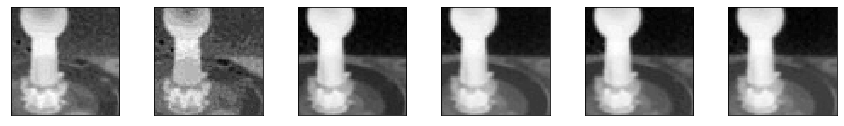

Reconstructed Pictures


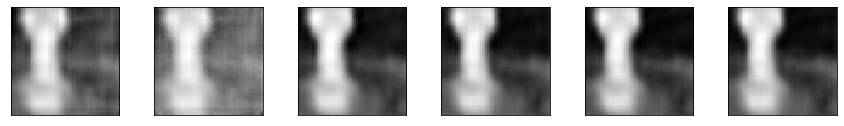

Error Map


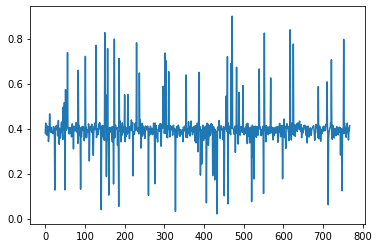


NOVEL IMAGE 0:
Original Pictures:


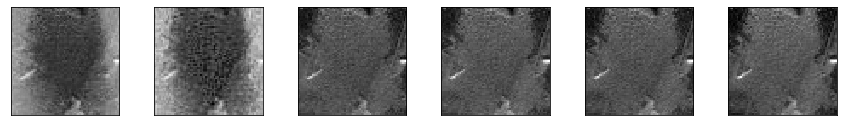

Reconstructed Pictures


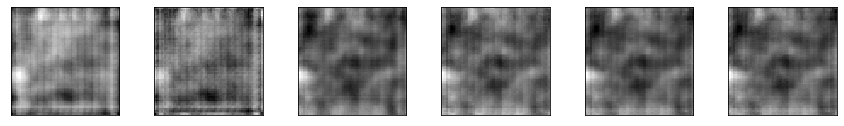

Error Map


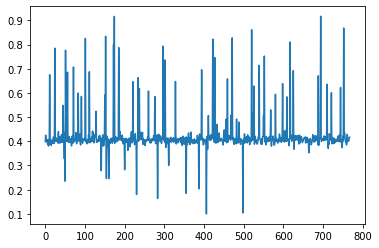

In [0]:
print('CHECK LEN')
print('losses_typical_img_train = ' + str(len(errormap_typical_train_path)))
print('losses_novel_img_train   = ' + str(len(errormap_typical_test_path)))
print('losses_typical_img_test  = ' + str(len(errormap_novel_train_path)))
print('losses_novel_img_test    = ' + str(len(errormap_novel_test_path)))

i = 1
print('\nTYPICAL IMAGE ' + str(i) + ':')
reconstruct_images(typical_train_path[i])
print('Error Map')
a = np.squeeze(load_images(errormap_typical_train_path[i]))
plt.plot(range(len(a)), a)
plt.show()

i = 0
print('\nNOVEL IMAGE ' + str(i) + ':')
reconstruct_images(novel_train_path[i])
print('Error Map')
b = np.squeeze(load_images(errormap_novel_train_path[i]))
plt.plot(range(len(b)), b)
plt.show()

In [0]:
def setup_dataset(x, y):
  images = x

  batch_size = 100
  dataset = tf.data.Dataset.from_tensor_slices((images, y)).shuffle(len(images)).batch(batch_size)
  return dataset

def setup_dataset_no_shuffle(x, y):
  images = x

  batch_size = 100
  dataset = tf.data.Dataset.from_tensor_slices((images, y)).batch(batch_size)
  return dataset

In [0]:
class classifier_model(tf.keras.Model):
    def __init__(self):
        super(classifier_model, self).__init__()
        self.classifier_nn = tf.keras.models.Sequential([
                             tf.keras.layers.Input(shape = (768,)),
                             #tf.keras.layers.Dense(1000, activation='relu'),
                             #tf.keras.layers.Dense(2000, activation='relu'),
                             #tf.keras.layers.Dense(2000, activation='relu'),
                             tf.keras.layers.Dense(1000, activation='relu'),
                             tf.keras.layers.Dense(500, activation='relu'),
                             #tf.keras.layers.Dropout(rate=0.4),
                             tf.keras.layers.Dense(1)
                             ], name='Classifier')

    def classify(self, x):
        logits = self.classifier_nn(x)
        prob   = tf.math.sigmoid(logits)
        return logits, prob

classifier = classifier_model()
classifier.classifier_nn.summary()

Model: "Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1000)              769000    
_________________________________________________________________
dense_5 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 501       
Total params: 1,270,001
Trainable params: 1,270,001
Non-trainable params: 0
_________________________________________________________________


In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001) #0.0001
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [0]:
def train_step(model, x, y, optimizer):
    with tf.GradientTape() as tape:
        loss = calculate_loss(model, x, y)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)

def test_step(model, x, y, optimizer):
    loss = calculate_loss(model, x)
    test_loss(loss)

def train_only_dataset(model, train_dataset, epochs):  
  for epoch in range(epochs):
    for train_x, train_y in train_dataset: 
      
      train_step(model, train_x, train_y, optimizer)
      
    loss = train_loss.result()
     
  train_loss.reset_states()
  return loss

In [0]:
def calculate_loss(model, x, y):
    logits, prob = model.classify(x)
    labels = y

    weight = 1000/100
      
    loss = tf.nn.weighted_cross_entropy_with_logits(labels = labels, logits = logits, pos_weight = weight)
    loss = tf.reduce_mean(loss)

    return loss

In [0]:
classifier = classifier_model()
#classifier.classifier_nn.load_weights('/content/drive/My Drive/SPACE_DATA/Novelty_Classifier_Balanced_12/')

4.47---> 1.7635347


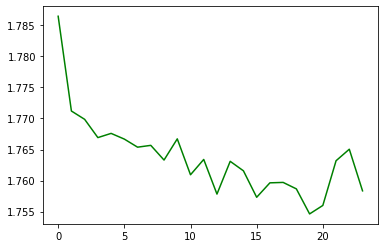

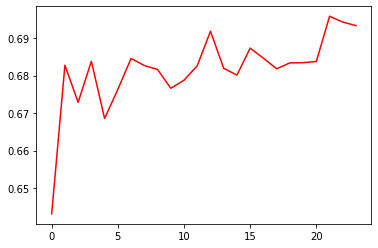

TRAINING TIME = 134.72182965278625



In [0]:
start_time = time.time()

losses = []

losses_test = []
test_data = np.append(errormap_novel_test_path, errormap_typical_test_path)
test_labels = np.zeros([len(test_data), 1]).astype('float32')
test_labels[0:N_novel_images_test, 0] = 1

epochs = 5

x = 0 
for j in range(epochs):
  if x == 1: break
  typical = shuffle(errormap_typical_train_path)

  for i in range(48):
    novel = shuffle(errormap_novel_train_path)
    train_data = np.append(novel[0:100], typical[i*1000:(i+1)*1000])
    train_labels = np.zeros([len(train_data), 1]).astype('float32')
    train_labels[0:N_novel_images_train, 0] = 1
    dataset = setup_dataset(load_images(train_data), train_labels)
    loss = train_only_dataset(classifier, dataset, 1)
    losses = np.append(losses, loss.numpy())

    logits, _ = classifier.classify(load_images(test_data))
    logits = np.array(logits[:,0])
    _, _, _, _, l, _ = threshold_ROC(test_labels, logits, 'NN classifier', plot=False)
    losses_test = np.append(losses_test, l)


    x1 = np.mean(losses_test[-(1+10):-(1)])
    x2 = np.mean(losses_test[-(20):-(10)])
    x3 = np.mean(losses_test[-(30):-(20)])
    if x3 > x2 and x2 > x1:
      print(l)
      #x = 1
      #break

    if len(losses)%10 == 0 and i>1:
      clear_output()
      print(str(j) + '.' + str(i) + '---> ' + str(loss.numpy()))

      a = np.reshape(losses, [-1,10])
      a = np.mean(a, axis=1)
      plt.plot(range(len(a)), a, color='green')
      plt.show()

      b = np.reshape(losses_test, [-1,10])
      b = np.mean(b, axis=1)
      plt.plot(range(len(b)), b, color='red')
      plt.show()

  #classifier.classifier_nn.save_weights('/content/drive/My Drive/SPACE_DATA/Novelty_Classifier/')

print('TRAINING TIME = {}\n'.format(time.time()-start_time))

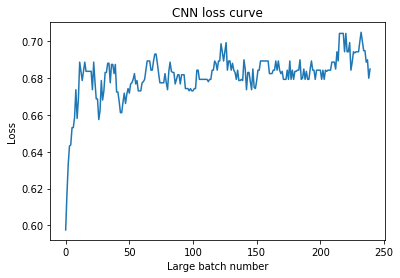

ValueError: ignored

In [0]:
l = losses_test

plt.plot(range(len(l)), l)
plt.title('CNN loss curve')
plt.xlabel('Large batch number')
plt.ylabel('Loss')
plt.savefig('/content/ROC_losses_graph/loss_curve_12')
plt.show()


a = np.reshape(l, [-1,49])
a = np.mean(a, axis=1)
plt.plot(range(len(a)), a)
plt.show()

a = np.reshape(l, [-1,98])
a = np.mean(a, axis=1)
plt.plot(range(len(a)), a)
plt.show()

In [0]:
test_data = np.append(errormap_novel_test_path, errormap_typical_test_path)
y_true = np.zeros([len(test_data),]).astype('int')
y_true[0:N_novel_images_test] = 1
test_data, y_true = shuffle(test_data, y_true, random_state=0)

test_images = load_images(test_data)
logits, prob = classifier.classify(test_images)
logits = np.array(logits[:,0])
prob = np.array(prob[:,0])

#print(logits)
print(prob)

[0.7735381  0.85993975 0.81178445 0.8211221  0.7969685  0.7770578
 0.7591631  0.84551483 0.7979269  0.77120095 0.75820047 0.8125038
 0.77735955 0.8170332  0.85274357 0.82394624 0.73930365 0.77130145
 0.81447303 0.8045315  0.8021505  0.8484249  0.81596625 0.7929385
 0.82829684 0.78793424 0.80133855 0.73363525 0.7629147  0.8257463
 0.7897429  0.7673611  0.7836064  0.78174716 0.7830629  0.80524015
 0.7596567  0.8165128  0.791859   0.74236506 0.8170039  0.82142943
 0.8223696  0.8074468  0.8049068  0.82682276 0.8063769  0.7862691
 0.74165666 0.76147753 0.7589591  0.7498935  0.78733945 0.727484
 0.8329474  0.8229971  0.8311926  0.7820958  0.7917811  0.8278619
 0.75695735 0.73811835 0.79813915 0.80761963 0.8054448  0.79923457
 0.78872687 0.810688   0.73740745 0.7802111  0.81679595 0.7954475
 0.8303565  0.80942136 0.7855522  0.76712084 0.77431154 0.8306984
 0.8179767  0.8118706  0.75890595 0.83220613 0.79997694 0.78125393
 0.7872354  0.8548705  0.7520598  0.7528537  0.78557426 0.81685317
 0.81

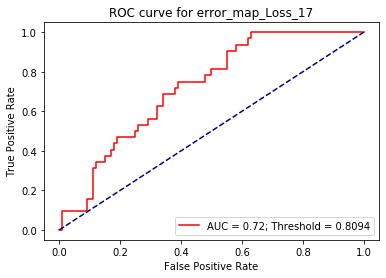

,Accuracy,Avg_accuracy,True Pos.,False Pos.,True Neg.,False Neg.,AUC
0,51.5,66.9,31,63,37,1,72.1


In [0]:
auc_value, threshold_value, _, _, _, threshold_avg_value = threshold_ROC(y_true, prob, 'error_map_Loss_'+str(loss_num), plot=True)
y_predicted = np.zeros([len(y_true),])
y_predicted[np.where(prob > threshold_avg_value)] = 1 

table_of_counts = np.zeros([2,2])
for j in range(len(y_true),):
  if y_true[j] == 0:
    if y_predicted[j] == 0:
      table_of_counts[0,0] += 1
    else: table_of_counts[0,1] += 1
  if y_true[j] == 1:
    if y_predicted[j] == 0:
      table_of_counts[1,0] += 1
    else: table_of_counts[1,1] += 1

true_positive = table_of_counts[1,1]
false_positive = table_of_counts[0,1]
true_negative = table_of_counts[0,0]
false_negative = table_of_counts[1,0]

accuracy = (true_positive+true_negative)/len(y_true)
avg_accuracy = np.mean([true_positive/(true_positive+false_negative),true_negative/(true_negative+false_positive)])

result_table = np.empty([1,7])
index = ['_']*1
result_table[0,0] = "{0:.1f}".format(accuracy*100)
result_table[0,1] = "{0:.1f}".format(avg_accuracy*100)
result_table[0,2] = table_of_counts[1,1].astype('int')
result_table[0,3] = table_of_counts[0,1].astype('int')
result_table[0,4] = table_of_counts[0,0].astype('int')
result_table[0,5] = table_of_counts[1,0].astype('int')
result_table[0,6] = "{0:.1f}".format(auc_value*100)
index = 'Loss_1'
df = pd.DataFrame(result_table, columns = ['Accuracy', 'Avg_accuracy', 'True Pos.', 'False Pos.', 'True Neg.', 'False Neg.','AUC'])
df.astype(str).replace('\.0', '', regex=True)

# MIXED LOSSES

## LATENT SPACE

In [4]:
errormap_typical_train_path = []
errormap_typical_test_path = []
errormap_novel_train_path = []
errormap_novel_test_path = []

for i in range(48700):
  errormap_typical_train_path.append('/content/error_map_typical_train/'+str(i)+'.npy')

for i in range(100):
  errormap_typical_test_path.append('/content/error_map_typical_test/'+str(i)+'.npy')

for i in range(300):
  errormap_novel_train_path.append('/content/error_map_novel_train/'+str(i)+'.npy')

for i in range(32):
  errormap_novel_test_path.append('/content/error_map_novel_test/'+str(i)+'.npy')

print('losses_typical_img_train = ' + str(len(errormap_typical_train_path)))
print('losses_novel_img_train   = ' + str(len(errormap_typical_test_path)))
print('losses_typical_img_test  = ' + str(len(errormap_novel_train_path)))
print('losses_novel_img_test    = ' + str(len(errormap_novel_test_path)))

losses_typical_img_train = 48700
losses_novel_img_train   = 100
losses_typical_img_test  = 300
losses_novel_img_test    = 32


In [0]:
#!rm -rf error_map_typical_train
#!rm -rf error_map_typical_test
#!rm -rf error_map_novel_train
#!rm -rf error_map_novel_test

In [0]:
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_17/typical_train.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_17/typical_test.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_17/novel_train.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_17/novel_test.zip'

!mv /content/typical_train /content/error_map_typical_train
!mv /content/typical_test /content/error_map_typical_test
!mv /content/novel_train /content/error_map_novel_train
!mv /content/novel_test /content/error_map_novel_test

clear_output()

In [0]:
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_16/typical_train.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_16/typical_test.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_16/novel_train.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_16/novel_test.zip'

for i in range(len(errormap_typical_train_path)):
  a = load_images(errormap_typical_train_path[i])
  b = load_images('/content/typical_train/'+str(i)+'.npy')
  c = np.append(a, b, axis=0)
  np.save(errormap_typical_train_path[i], c)

for i in range(len(errormap_typical_test_path)):
  a = load_images(errormap_typical_test_path[i])
  b = load_images('/content/typical_test/'+str(i)+'.npy')
  c = np.append(a, b, axis=0)
  np.save(errormap_typical_test_path[i], c)

for i in range(len(errormap_novel_train_path)):
  a = load_images(errormap_novel_train_path[i])
  b = load_images('/content/novel_train/'+str(i)+'.npy')
  c = np.append(a, b, axis=0)
  np.save(errormap_novel_train_path[i], c)

for i in range(len(errormap_novel_test_path)):
  a = load_images(errormap_novel_test_path[i])
  b = load_images('/content/novel_test/'+str(i)+'.npy')
  c = np.append(a, b, axis=0)
  np.save(errormap_novel_test_path[i], c)

!rm -rf typical_train
!rm -rf typical_test
!rm -rf novel_train
!rm -rf novel_test

clear_output()

In [0]:
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_15/typical_train.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_15/typical_test.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_15/novel_train.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_15/novel_test.zip'

for i in range(len(errormap_typical_train_path)):
  a = np.load(errormap_typical_train_path[i])
  b = load_images('/content/typical_train/'+str(i)+'.npy')
  c = np.append(a, b, axis=0)
  np.save(errormap_typical_train_path[i], c)

for i in range(len(errormap_typical_test_path)):
  a = np.load(errormap_typical_test_path[i])
  b = load_images('/content/typical_test/'+str(i)+'.npy')
  c = np.append(a, b, axis=0)
  np.save(errormap_typical_test_path[i], c)

for i in range(len(errormap_novel_train_path)):
  a = np.load(errormap_novel_train_path[i])
  b = load_images('/content/novel_train/'+str(i)+'.npy')
  c = np.append(a, b, axis=0)
  np.save(errormap_novel_train_path[i], c)

for i in range(len(errormap_novel_test_path)):
  a = np.load(errormap_novel_test_path[i])
  b = load_images('/content/novel_test/'+str(i)+'.npy')
  c = np.append(a, b, axis=0)
  np.save(errormap_novel_test_path[i], c)

!rm -rf typical_train
!rm -rf typical_test
!rm -rf novel_train
!rm -rf novel_test

clear_output()

In [0]:
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_14/typical_train.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_14/typical_test.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_14/novel_train.zip'
!unzip '/content/drive/My Drive/SPACE_DATA/Losses_14/novel_test.zip'

for i in range(len(errormap_typical_train_path)):
  a = np.load(errormap_typical_train_path[i])
  b = load_images('/content/typical_train/'+str(i+50000)+'.npy')
  c = np.append(a, b, axis=0)
  np.save(errormap_typical_train_path[i], c)

for i in range(len(errormap_typical_test_path)):
  a = np.load(errormap_typical_test_path[i])
  b = load_images('/content/typical_test/'+str(i)+'.npy')
  c = np.append(a, b, axis=0)
  np.save(errormap_typical_test_path[i], c)

for i in range(len(errormap_novel_train_path)):
  a = np.load(errormap_novel_train_path[i])
  b = load_images('/content/novel_train/'+str(i)+'.npy')
  c = np.append(a, b, axis=0)
  np.save(errormap_novel_train_path[i], c)

for i in range(len(errormap_novel_test_path)):
  a = np.load(errormap_novel_test_path[i])
  b = load_images('/content/novel_test/'+str(i)+'.npy')
  c = np.append(a, b, axis=0)
  np.save(errormap_novel_test_path[i], c)

!rm -rf typical_train
!rm -rf typical_test
!rm -rf novel_train
!rm -rf novel_test

clear_output()

In [0]:
print('CHECK LEN')
print('losses_typical_img_train = ' + str(len(errormap_typical_train_path)))
print('losses_novel_img_train   = ' + str(len(errormap_typical_test_path)))
print('losses_typical_img_test  = ' + str(len(errormap_novel_train_path)))
print('losses_novel_img_test    = ' + str(len(errormap_novel_test_path)))

i = 0
#print('\nTYPICAL IMAGE ' + str(i) + ':')
#reconstruct_images(typical_train_path[i])
print('\nError Map Typical Image')
a = np.squeeze(load_images(errormap_typical_train_path[i]))
plt.plot(range(a.shape[1]), a[0,:])
plt.show()

i = 1
#print('\nNOVEL IMAGE ' + str(i) + ':')
#reconstruct_images(novel_train_path[i])
print('Error Map Novel Image')
b = np.squeeze(load_images(errormap_novel_train_path[i]))
plt.plot(range(b.shape[1]), b[0,:])
plt.show()

In [0]:
def setup_dataset(x, y):
  images = x

  batch_size = 100
  dataset = tf.data.Dataset.from_tensor_slices((images, y)).shuffle(len(images)).batch(batch_size)
  return dataset

def setup_dataset_no_shuffle(x, y):
  images = x

  batch_size = 100
  dataset = tf.data.Dataset.from_tensor_slices((images, y)).batch(batch_size)
  return dataset

In [283]:
class classifier_model(tf.keras.Model):
    def __init__(self):
        super(classifier_model, self).__init__()
        self.classifier_nn = tf.keras.models.Sequential([
                             tf.keras.layers.Input(shape = (1, 768, 4)),
                             tf.keras.layers.Conv2D(50, (1,1), strides = (1,1), padding = 'Valid', activation='relu'),
                             tf.keras.layers.Conv2D(20, (1,1), strides = (1,1), padding = 'Valid', activation='relu'),
                             tf.keras.layers.Conv2D(8, (1,1), strides = (1,1), padding = 'Valid', activation='relu'),
                             tf.keras.layers.Conv2D(1, (1,1), strides = (1,1), padding = 'Valid', activation='relu'),
                             tf.keras.layers.Flatten(),                             
                             #tf.keras.layers.Dense(1000, activation='relu'),
                             #tf.keras.layers.Dense(2000, activation='relu'),
                             #tf.keras.layers.Dense(2000, activation='relu'),
                             tf.keras.layers.Dense(1000, activation='relu'),
                             tf.keras.layers.Dense(500, activation='relu'),
                             #tf.keras.layers.Dropout(rate=0.4),
                             tf.keras.layers.Dense(1)
                             ], name='Classifier')

    def classify(self, x):
        logits = self.classifier_nn(x)
        prob   = tf.math.sigmoid(logits)
        return logits, prob

classifier = classifier_model()
classifier.classifier_nn.summary()

Model: "Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 1, 768, 50)        250       
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 1, 768, 20)        1020      
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 1, 768, 8)         168       
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 1, 768, 1)         9         
_________________________________________________________________
flatten_49 (Flatten)         (None, 768)               0         
_________________________________________________________________
dense_193 (Dense)            (None, 1000)              769000    
_________________________________________________________________
dense_194 (Dense)            (None, 500)               5

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001) #0.0001
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [0]:
def train_step(model, x, y, optimizer):
    with tf.GradientTape() as tape:
        loss = calculate_loss(model, x, y)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)

def test_step(model, x, y, optimizer):
    loss = calculate_loss(model, x)
    test_loss(loss)

def train_only_dataset(model, train_dataset, epochs):  
  for epoch in range(epochs):
    for train_x, train_y in train_dataset: 
      
      train_step(model, train_x, train_y, optimizer)
      
    loss = train_loss.result()
     
  train_loss.reset_states()
  return loss

In [0]:
def calculate_loss(model, x, y):
    logits, prob = model.classify(x)
    labels = y

    weight = 1000/100
      
    loss = tf.nn.weighted_cross_entropy_with_logits(labels = labels, logits = logits, pos_weight = weight)
    loss = tf.reduce_mean(loss)

    return loss

In [0]:
classifier = classifier_model()
#classifier.classifier_nn.load_weights('/content/drive/My Drive/SPACE_DATA/Novelty_Classifier_Balanced_12/')

In [0]:
N_novel_images_test = 32
N_novel_images_train =300

In [0]:
start_time = time.time()

losses = []

losses_test = []
test_data = np.append(errormap_novel_test_path, errormap_typical_test_path)
test_labels = np.zeros([len(test_data), 1]).astype('float32')
test_labels[0:N_novel_images_test, 0] = 1

epochs = 10

x = 0 
for j in range(epochs):
  if x == 1: break
  typical = shuffle(errormap_typical_train_path)

  for i in range(48):
    novel = shuffle(errormap_novel_train_path)
    train_data = np.append(novel[0:100], typical[i*1000:(i+1)*1000])
    train_labels = np.zeros([len(train_data), 1]).astype('float32')
    train_labels[0:N_novel_images_train, 0] = 1
    dataset = setup_dataset(np.expand_dims(np.swapaxes(load_images(train_data), 1, 2), 1), train_labels)
    loss = train_only_dataset(classifier, dataset, 1)
    losses = np.append(losses, loss.numpy())

    logits, _ = classifier.classify(np.expand_dims(np.swapaxes(load_images(test_data), 1, 2), 1))
    logits = np.array(logits[:,0])
    _, _, _, _, l, _ = threshold_ROC(test_labels, logits, 'NN classifier', plot=False)
    losses_test = np.append(losses_test, l)


    #x1 = np.mean(losses_test[-(1+10):-(1)])
    #x2 = np.mean(losses_test[-(20):-(10)])
    #x3 = np.mean(losses_test[-(30):-(20)])
    #if x3 > x2 and x2 > x1:
    #  print(l)
      #x = 1
      #break

    if len(losses)%10 == 0 and i>1:
      clear_output()
      print(str(j) + '.' + str(i) + '---> ' + str(loss.numpy()))

      a = np.reshape(losses, [-1,10])
      a = np.mean(a, axis=1)
      plt.plot(range(len(a)), a, color='green')
      plt.show()

      b = np.reshape(losses_test, [-1,10])
      b = np.mean(b, axis=1)
      plt.plot(range(len(b)), b, color='red')
      plt.show()

print('TRAINING TIME = {}\n'.format(time.time()-start_time))

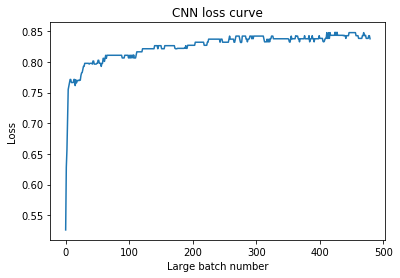

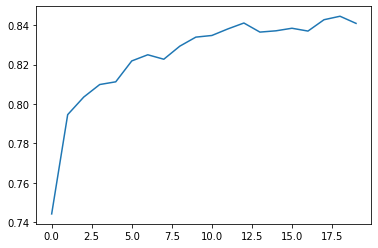

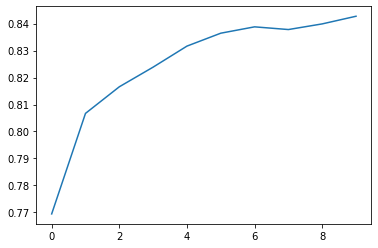

In [290]:
l = losses_test

plt.plot(range(len(l)), l)
plt.title('CNN loss curve')
plt.xlabel('Large batch number')
plt.ylabel('Loss')
#plt.savefig('/content/ROC_losses_graph/loss_curve_12')
plt.show()


a = np.reshape(l, [-1,24])
a = np.mean(a, axis=1)
plt.plot(range(len(a)), a)
plt.show()

a = np.reshape(l, [-1,48])
a = np.mean(a, axis=1)
plt.plot(range(len(a)), a)
plt.show()

In [291]:
test_data = np.append(errormap_novel_test_path, errormap_typical_test_path)
y_true = np.zeros([len(test_data),]).astype('int')
y_true[0:N_novel_images_test] = 1
test_data, y_true = shuffle(test_data, y_true, random_state=0)

test_images = np.expand_dims(np.swapaxes(load_images(test_data), 1, 2), 1)
logits, prob = classifier.classify(test_images)
logits = np.array(logits[:,0])
prob = np.array(prob[:,0])

#print(logits)
print(prob)

[0.6993263  0.72095734 0.80665654 0.7723515  0.7859721  0.73360616
 0.68624544 0.6893837  0.6869555  0.7016126  0.71400225 0.7391584
 0.8408901  0.6882678  0.8895972  0.7304733  0.7703145  0.85575885
 0.88554657 0.86398613 0.7062246  0.8434072  0.7542319  0.71050495
 0.9218081  0.9301929  0.73680776 0.8820784  0.7415344  0.8413098
 0.7481966  0.8056557  0.7209476  0.78638536 0.77167636 0.828317
 0.8701978  0.83775645 0.72603506 0.8032339  0.9206857  0.8186966
 0.86650956 0.86025834 0.70864946 0.86108524 0.80438054 0.86775297
 0.7001952  0.84419984 0.75727534 0.7708446  0.78906584 0.70883334
 0.8990191  0.6908421  0.92513376 0.82406205 0.74169976 0.9285796
 0.7744807  0.7727913  0.7087905  0.7307691  0.76304466 0.7492897
 0.7666698  0.70370597 0.7373022  0.70569843 0.8286596  0.94135845
 0.7402368  0.80421174 0.77081347 0.7747636  0.7330152  0.87797016
 0.80981594 0.8740086  0.70049256 0.8552684  0.72655874 0.90254897
 0.76840025 0.8651138  0.7801019  0.71142715 0.7295971  0.7544544
 0.

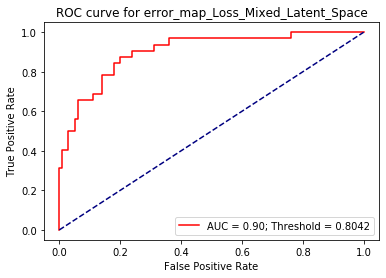

,Accuracy,Avg_accuracy,True Pos.,False Pos.,True Neg.,False Neg.,AUC
0,81.1,82.2,27,20,80,5,90.1


In [292]:
loss_num = 'Mixed_Latent_Space'

auc_value, threshold_value, _, _, _, threshold_avg_value = threshold_ROC(y_true, prob, 'error_map_Loss_'+str(loss_num), plot=True)
y_predicted = np.zeros([len(y_true),])
y_predicted[np.where(prob > threshold_avg_value)] = 1 

table_of_counts = np.zeros([2,2])
for j in range(len(y_true),):
  if y_true[j] == 0:
    if y_predicted[j] == 0:
      table_of_counts[0,0] += 1
    else: table_of_counts[0,1] += 1
  if y_true[j] == 1:
    if y_predicted[j] == 0:
      table_of_counts[1,0] += 1
    else: table_of_counts[1,1] += 1

true_positive = table_of_counts[1,1]
false_positive = table_of_counts[0,1]
true_negative = table_of_counts[0,0]
false_negative = table_of_counts[1,0]

accuracy = (true_positive+true_negative)/len(y_true)
avg_accuracy = np.mean([true_positive/(true_positive+false_negative),true_negative/(true_negative+false_positive)])

result_table = np.empty([1,7])
index = ['_']*1
result_table[0,0] = "{0:.1f}".format(accuracy*100)
result_table[0,1] = "{0:.1f}".format(avg_accuracy*100)
result_table[0,2] = table_of_counts[1,1].astype('int')
result_table[0,3] = table_of_counts[0,1].astype('int')
result_table[0,4] = table_of_counts[0,0].astype('int')
result_table[0,5] = table_of_counts[1,0].astype('int')
result_table[0,6] = "{0:.1f}".format(auc_value*100)
index = 'Loss_1'
df = pd.DataFrame(result_table, columns = ['Accuracy', 'Avg_accuracy', 'True Pos.', 'False Pos.', 'True Neg.', 'False Neg.','AUC'])
df.astype(str).replace('\.0', '', regex=True)

## ELBO

In [0]:
os.mkdir('/content/error_map_typical_train/')
os.mkdir('/content/error_map_typical_test/')
os.mkdir('/content/error_map_novel_train/')
os.mkdir('/content/error_map_novel_test/')

In [30]:
loss_num = 4
time1 = time.time()

print('Progress of error_map_typical_train')
for i in range(len(typical_train_path)):
    if i%(len(typical_train_path)/100*5) == 0: print(str(int(i/len(typical_train_path)*100)) + '%,', end = ' ')
    images = load_images(typical_train_path[i])
    dataset = setup_dataset(images.astype('float32'))
    loss = Loss_functions_img_dict[loss_num](model, dataset)
    loss = np.squeeze(loss).astype('float32')
    np.save('/content/error_map_typical_train/'+str(i), loss)
print('100%')

print('\nProgress of error_map_typical_test')
for i in range(len(typical_test_path)):
    if i%100 == 0: print(str(i/1000*100) + '%,', end = ' ')
    images = load_images(typical_test_path[i])
    dataset = setup_dataset(images.astype('float32'))
    loss = Loss_functions_img_dict[loss_num](model, dataset)
    loss = np.squeeze(loss).astype('float32')
    np.save('/content/error_map_typical_test/'+str(i), loss)
print('100%')

print('\nProgress of error_map_novel_train')
for i in range(len(novel_train_path)):
    if i%17 == 0: print(str(i/170*100) + '%,', end = ' ')
    images = load_images(novel_train_path[i])
    dataset = setup_dataset(images.astype('float32'))
    loss = Loss_functions_img_dict[loss_num](model, dataset)
    loss = np.squeeze(loss).astype('float32')
    np.save('/content/error_map_novel_train/'+str(i), loss)
print('100%')

print('\nProgress of error_map_novel_test')
for i in range(len(novel_test_path)):
    if i%17 == 0: print(str(i/170*100) + '%,', end = ' ')
    images = load_images(novel_test_path[i])
    dataset = setup_dataset(images.astype('float32'))
    loss = Loss_functions_img_dict[loss_num](model, dataset)
    loss = np.squeeze(loss).astype('float32')
    np.save('/content/error_map_novel_test/'+str(i), loss)
print('100%')

print(time.time()-time1)

Progress of error_map_typical_train
0%, 5%, 10%, 15%, 20%, 25%, 30%, 35%, 40%, 45%, 50%, 55%, 60%, 65%, 70%, 75%, 80%, 85%, 90%, 95%, 100%

Progress of error_map_typical_test
0.0%, 100%

Progress of error_map_novel_train
0.0%, 10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100.0%, 110.00000000000001%, 120.0%, 130.0%, 140.0%, 150.0%, 160.0%, 170.0%, 100%

Progress of error_map_novel_test
0.0%, 10.0%, 100%
1780.9166152477264


In [31]:
errormap_typical_train_path = []
errormap_typical_test_path = []
errormap_novel_train_path = []
errormap_novel_test_path = []

for i in range(98700):
  errormap_typical_train_path.append('/content/error_map_typical_train/'+str(i)+'.npy')

for i in range(100):
  errormap_typical_test_path.append('/content/error_map_typical_test/'+str(i)+'.npy')

for i in range(300):
  errormap_novel_train_path.append('/content/error_map_novel_train/'+str(i)+'.npy')

for i in range(32):
  errormap_novel_test_path.append('/content/error_map_novel_test/'+str(i)+'.npy')

print('losses_typical_img_train = ' + str(len(errormap_typical_train_path)))
print('losses_novel_img_train   = ' + str(len(errormap_typical_test_path)))
print('losses_typical_img_test  = ' + str(len(errormap_novel_train_path)))
print('losses_novel_img_test    = ' + str(len(errormap_novel_test_path)))

losses_typical_img_train = 98700
losses_novel_img_train   = 100
losses_typical_img_test  = 300
losses_novel_img_test    = 32


In [0]:
os.mkdir('/content/latent_map_typical_train/')
os.mkdir('/content/latent_map_typical_test/')
os.mkdir('/content/latent_map_novel_train/')
os.mkdir('/content/latent_map_novel_test/')

In [33]:
loss_num = 14
time1 = time.time()

print('Progress of latent_map_typical_train')
for i in range(len(typical_train_path)):
    if i%(len(typical_train_path)/100*5) == 0: print(str(int(i/len(typical_train_path)*100)) + '%,', end = ' ')
    images = load_images(typical_train_path[i])
    dataset = setup_dataset(images.astype('float32'))
    loss = Loss_functions_img_dict[loss_num](model, dataset)
    loss = np.squeeze(loss).astype('float32')
    np.save('/content/latent_map_typical_train/'+str(i), loss)
print('100%')

print('\nProgress of latent_map_typical_test')
for i in range(len(typical_test_path)):
    if i%100 == 0: print(str(i/1000*100) + '%,', end = ' ')
    images = load_images(typical_test_path[i])
    dataset = setup_dataset(images.astype('float32'))
    loss = Loss_functions_img_dict[loss_num](model, dataset)
    loss = np.squeeze(loss).astype('float32')
    np.save('/content/latent_map_typical_test/'+str(i), loss)
print('100%')

print('\nProgress of latent_map_novel_train')
for i in range(len(novel_train_path)):
    if i%17 == 0: print(str(i/170*100) + '%,', end = ' ')
    images = load_images(novel_train_path[i])
    dataset = setup_dataset(images.astype('float32'))
    loss = Loss_functions_img_dict[loss_num](model, dataset)
    loss = np.squeeze(loss).astype('float32')
    np.save('/content/latent_map_novel_train/'+str(i), loss)
print('100%')

print('\nProgress of latent_map_novel_test')
for i in range(len(novel_test_path)):
    if i%17 == 0: print(str(i/170*100) + '%,', end = ' ')
    images = load_images(novel_test_path[i])
    dataset = setup_dataset(images.astype('float32'))
    loss = Loss_functions_img_dict[loss_num](model, dataset)
    loss = np.squeeze(loss).astype('float32')
    np.save('/content/latent_map_novel_test/'+str(i), loss)
print('100%')

print(time.time()-time1)

Progress of latent_map_typical_train
0%, 5%, 10%, 15%, 20%, 25%, 30%, 35%, 40%, 45%, 50%, 55%, 60%, 65%, 70%, 75%, 80%, 85%, 90%, 95%, 100%

Progress of latent_map_typical_test
0.0%, 100%

Progress of latent_map_novel_train
0.0%, 10.0%, 20.0%, 30.0%, 40.0%, 50.0%, 60.0%, 70.0%, 80.0%, 90.0%, 100.0%, 110.00000000000001%, 120.0%, 130.0%, 140.0%, 150.0%, 160.0%, 170.0%, 100%

Progress of latent_map_novel_test
0.0%, 10.0%, 100%
1097.5749979019165


In [34]:
latent_typical_train_path = []
latent_typical_test_path = []
latent_novel_train_path = []
latent_novel_test_path = []

for i in range(98700):
  latent_typical_train_path.append('/content/latent_map_typical_train/'+str(i)+'.npy')

for i in range(100):
  latent_typical_test_path.append('/content/latent_map_typical_test/'+str(i)+'.npy')

for i in range(300):
  latent_novel_train_path.append('/content/latent_map_novel_train/'+str(i)+'.npy')

for i in range(32):
  latent_novel_test_path.append('/content/latent_map_novel_test/'+str(i)+'.npy')

print('losses_typical_img_train = ' + str(len(latent_typical_train_path)))
print('losses_novel_img_train   = ' + str(len(latent_typical_test_path)))
print('losses_typical_img_test  = ' + str(len(latent_novel_train_path)))
print('losses_novel_img_test    = ' + str(len(latent_novel_test_path)))

losses_typical_img_train = 98700
losses_novel_img_train   = 100
losses_typical_img_test  = 300
losses_novel_img_test    = 32


In [0]:
input1 = tf.keras.layers.Input(shape = (64, 64, 6))
x1 = tf.keras.layers.Conv2D(32, (5,5), padding='SAME', activation='relu', name='x1')(input1)
x2 = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2, name='x2')(x1)
x3 = tf.keras.layers.Conv2D(64, (5,5), padding='SAME', activation='relu', name='x3')(x2)
x4 = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2, name='x4')(x3)
x5 = tf.keras.layers.Flatten(name='x5')(x4)

input2 = tf.keras.layers.Input(shape=(768,))

added = tf.keras.layers.concatenate([x5, input2])
added2 = tf.keras.layers.Dense(512, activation='relu', name='added2')(added)
out = tf.keras.layers.Dense(1, name='out')(added2)

classifier = tf.keras.models.Model(inputs=[input1, input2], outputs=out)

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001) #0.0001
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [0]:
def calculate_loss(model, x1, x2, y):
    logits = model([x1, x2])
    labels = y

    weight = 1000/100
      
    loss = tf.nn.weighted_cross_entropy_with_logits(labels = labels, logits = logits, pos_weight = weight)
    loss = tf.reduce_mean(loss)

    return loss

In [0]:
def train_step(model, x1, x2, y, optimizer):
    with tf.GradientTape() as tape:
        loss = calculate_loss(model, x1, x2, y)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)

def test_step(model, x1, x2, y, optimizer):
    loss = calculate_loss(model, x1, x2)
    test_loss(loss)

def train_only_dataset(model, train_dataset1, train_dataset2, epochs):  
  for epoch in range(epochs):
    for data1, data2 in zip(train_dataset1, train_dataset2):
      train_x1 = data1[0]
      train_y = data1[1]
      train_x2 = data2[0]
      train_step(model, train_x1, train_x2, train_y, optimizer)
      
    loss = train_loss.result()
     
  train_loss.reset_states()
  return loss

In [0]:
def setup_dataset(x, y):
  images = x

  batch_size = 100
  dataset = tf.data.Dataset.from_tensor_slices((images, y)).shuffle(len(images)).batch(batch_size)
  return dataset

def setup_dataset_no_shuffle(x, y):
  images = x

  batch_size = 100
  dataset = tf.data.Dataset.from_tensor_slices((images, y)).batch(batch_size)
  return dataset

In [0]:
classifier = tf.keras.models.Model(inputs=[input1, input2], outputs=out)
#classifier.classifier_nn.load_weights('/content/drive/My Drive/SPACE_DATA/Novelty_Classifier_Balanced_12/')

In [0]:
N_novel_images_test = 32
N_novel_images_train =300

2.95---> 1.6391797


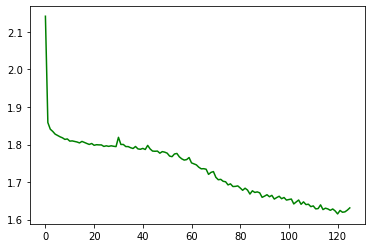

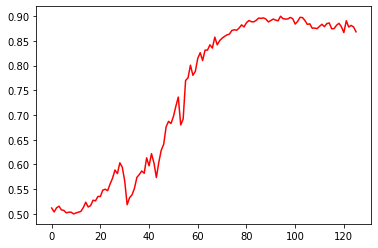

0.8125
0.08
TRAINING TIME = 1342.1271591186523



In [68]:
start_time = time.time()

#losses = []

#losses_test = []
test_data1 = np.append(errormap_novel_test_path, errormap_typical_test_path)
test_data2 = np.append(latent_novel_test_path, latent_typical_test_path)
test_labels = np.zeros([len(test_data1), 1]).astype('float32')
test_labels[0:N_novel_images_test, 0] = 1

epochs = 3

loss_max = 0

x = 0
for j in range(epochs):
  errormap_typical_train_path, latent_typical_train_path = shuffle(errormap_typical_train_path, latent_typical_train_path)
  if x == 1: break

  for i in range(97):
    errormap_novel_train_path, latent_novel_train_path,  = shuffle(errormap_novel_train_path, latent_novel_train_path)
    train_data1 = np.append(errormap_novel_train_path[0:100], errormap_typical_train_path[i*1000:(i+1)*1000])
    train_data2 = np.append(latent_novel_train_path[0:100], latent_typical_train_path[i*1000:(i+1)*1000])
    train_labels = np.zeros([len(train_data1), 1]).astype('float32')
    train_labels[0:N_novel_images_train, 0] = 1
    dataset1 = setup_dataset_no_shuffle(load_images(train_data1), train_labels)
    dataset2 = setup_dataset_no_shuffle(load_images(train_data2), train_labels)
    loss = train_only_dataset(classifier, dataset1, dataset2, 1)
    losses = np.append(losses, loss.numpy())

    logits = classifier([load_images(test_data1), load_images(test_data2)])
    logits = np.array(logits[:,0])
    _, _, _, _, l, _ = threshold_ROC(test_labels, logits, 'NN classifier', plot=False)
    losses_test = np.append(losses_test, l)

    if l > loss_max:
      classifier.save_weights('/content/Classifier_Weights/')
      loss_max = l
      print(loss_max)

    if len(losses)%10 == 0 and i>1:
      clear_output()
      print(str(j) + '.' + str(i) + '---> ' + str(loss.numpy()))

      a = np.reshape(losses, [-1,10])
      a = np.mean(a, axis=1)
      plt.plot(range(len(a)), a, color='green')
      plt.show()

      b = np.reshape(losses_test, [-1,10])
      b = np.mean(b, axis=1)
      plt.plot(range(len(b)), b, color='red')
      plt.show()

print('TRAINING TIME = {}\n'.format(time.time()-start_time))

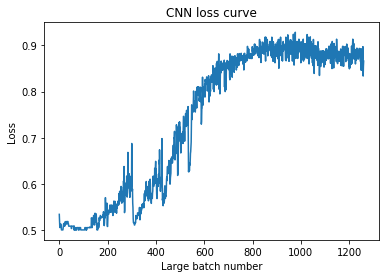

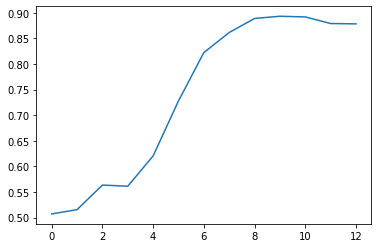

0.92875
0.86625


In [69]:
l = losses_test

plt.plot(range(len(l)), l)
plt.title('CNN loss curve')
plt.xlabel('Large batch number')
plt.ylabel('Loss')
#plt.savefig('/content/ROC_losses_graph/loss_curve_12')
plt.show()


a = np.reshape(l, [-1,97])
a = np.mean(a, axis=1)
plt.plot(range(len(a)), a)
plt.show()

print(max(l))
print(l[-1])

In [73]:
classifier.load_weights('/content/Classifier_Weights/')
logits = classifier([load_images(test_data1), load_images(test_data2)])
logits = np.array(logits[:,0])
prob = tf.sigmoid(logits)

print(prob)

tf.Tensor(
[0.99608994 0.88112426 0.8571167  1.         0.81086963 0.733107
 0.8079952  0.9247759  0.9199224  0.87387496 0.9966184  0.9951079
 0.7633181  0.80471426 0.9979589  0.9997043  0.8433953  0.99978536
 0.8737836  0.8698716  0.9424376  0.98969823 0.7911017  0.932446
 0.85108465 0.9761494  0.97157574 0.8249719  0.997227   0.978693
 0.9451808  0.9840088  0.7321742  0.69913137 0.7297442  0.7253637
 0.7420859  0.72594815 0.78537476 0.7010456  0.7406341  0.7165808
 0.67354536 0.74361426 0.69125485 0.7002812  0.82400715 0.7244965
 0.6848197  0.743036   0.6875929  0.71548563 0.7454299  0.6842469
 0.7154611  0.71966314 0.7120045  0.74782455 0.6902805  0.750287
 0.71152645 0.73909146 0.73606557 0.70459956 0.77146226 0.73652
 0.7033782  0.7616986  0.7657496  0.9362161  0.66703    0.7129518
 0.7415284  0.70668966 0.7611279  0.81873685 0.83471525 0.6840044
 0.6768422  0.7120304  0.6991094  0.73957074 0.68367046 0.71265584
 0.77773285 0.70040023 0.729581   0.76829433 0.74881995 0.7386832
 0.

In [0]:
def threshold_ROC(y_true, y_score, title, plot=True):
  fpr, tpr, threshold = roc_curve(y_true, y_score)
  roc_auc = auc(fpr, tpr)
  optimal_idx = np.argmin(np.sqrt(np.square(1-tpr) + np.square(fpr)))
  optimal_threshold = threshold[optimal_idx]

  optimal_accuracy_idx = np.argmax(tpr*32+((1-fpr)*100))
  optimal_accuracy = (tpr[optimal_accuracy_idx]*32+((1-fpr[optimal_accuracy_idx])*100))/132
  optimal_accuracy_threshold = threshold[optimal_accuracy_idx]

  optimal_avgaccuracy_idx = np.argmax(tpr + 1 - fpr)
  optimal_avgaccuracy = (tpr[optimal_avgaccuracy_idx]+1-fpr[optimal_avgaccuracy_idx])/2
  optimal_avgaccuracy_threshold = threshold[optimal_avgaccuracy_idx]

  if plot:
    plot = plt.figure()
    plt.plot(fpr, tpr, color='red', label='AUC = %0.2f; Threshold = %0.4f' % (roc_auc,optimal_threshold))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for ' + title)
    plt.legend(loc="lower right")
    plt.savefig('/content/ROC_losses_graph/'+str(title)+'.png')
    plt.show()
  return roc_auc, optimal_threshold, optimal_accuracy, optimal_accuracy_threshold, optimal_avgaccuracy, optimal_avgaccuracy_threshold

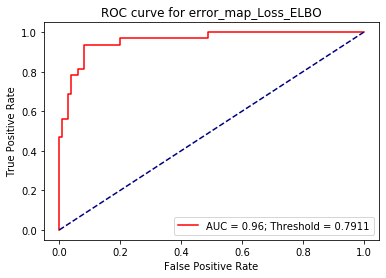

,Accuracy,Avg_accuracy,True Pos.,False Pos.,True Neg.,False Neg.,AUC
0,92.4,92.9,30,8,92,2,95.8


In [80]:
loss_num = 'ELBO'

auc_value, threshold_value, _, threshold_max_value, _, threshold_avg_value = threshold_ROC(test_labels, prob, 'error_map_Loss_'+str(loss_num), plot=True)
y_predicted = np.zeros([len(test_labels),])
y_predicted[np.where(prob >= threshold_max_value)] = 1 

table_of_counts = np.zeros([2,2])
for j in range(len(test_labels),):
  if test_labels[j] == 0:
    if y_predicted[j] == 0:
      table_of_counts[0,0] += 1
    else: table_of_counts[0,1] += 1
  if test_labels[j] == 1:
    if y_predicted[j] == 0:
      table_of_counts[1,0] += 1
    else: table_of_counts[1,1] += 1

true_positive = table_of_counts[1,1]
false_positive = table_of_counts[0,1]
true_negative = table_of_counts[0,0]
false_negative = table_of_counts[1,0]

accuracy = (true_positive+true_negative)/len(test_labels)
avg_accuracy = np.mean([true_positive/(true_positive+false_negative),true_negative/(true_negative+false_positive)])

result_table = np.empty([1,7])
index = ['_']*1
result_table[0,0] = "{0:.1f}".format(accuracy*100)
result_table[0,1] = "{0:.1f}".format(avg_accuracy*100)
result_table[0,2] = table_of_counts[1,1].astype('int')
result_table[0,3] = table_of_counts[0,1].astype('int')
result_table[0,4] = table_of_counts[0,0].astype('int')
result_table[0,5] = table_of_counts[1,0].astype('int')
result_table[0,6] = "{0:.1f}".format(auc_value*100)
index = 'Loss_1'
df = pd.DataFrame(result_table, columns = ['Accuracy', 'Avg_accuracy', 'True Pos.', 'False Pos.', 'True Neg.', 'False Neg.','AUC'])
df.astype(str).replace('\.0', '', regex=True)